In [90]:
# To support both python 2 and python 3
from __future__ import print_function, division, unicode_literals
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

# Usual imports
import numpy as np
import os
import cv2
import warnings
from os.path import join as path_join
from tqdm import tqdm
import json
tqdm.pandas()
import itertools
from datetime import datetime

from itertools import combinations, product

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option("display.max_columns", 100)

# while not os.getcwd().endswith("ml"):
#     os.chdir(os.path.abspath(os.path.join(os.pardir)))
print("Working dir:", os.getcwd())

from Common.analysis.analysis_tools import calculate_acceptable_precision_error
from Common.data_manipulation.pandas_tools import save_dataframe, add_face_id, load_df, separate_df_based_on_column_range, add_image_id
from Common.data_manipulation.dictionary_tools import convert_dict_lists_to_list_of_dicts, create_or_append_to_dict_of_lists, nested_dict_add_element

# from Common.paths.dataset_paths import 
from Common.image_tools.image_loading import load_image
from Common.image_tools.cropping import crop_box
from Common.image_tools.resizer import resize_image

from Common.data_manipulation.pickler import write_pickle, load_pickle

from Common.machine_learning_tools.model_tools.tensoflow_model_tools import initialize_memory_growth

from Common.miscellaneous import print_indexed_list, print_fraction, verbose_print
from Common.visualizations.image_visualizations import show_image, show_images, draw_pose, draw_bounding_box, draw_landmarks, draw_confidences
from Common.visualizations.figure_plotting import plot_histogram, plot_multiple_histograms, plot_scatter_historgram, plot_CED_curve, plot_multiple_CED_curves, plot_xy_curves, plot_xs_and_ys, plot_scatter_historgram

Working dir: D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT


In [5]:
experiments_path = path_join(os.getcwd(), "experiments")
data_filtering_path = path_join(os.getcwd(), "data_filtering")

In [6]:
train_csv_name = "training.csv"
results_csv_name = "results.csv"

MIN_CORRECT_LOSS = 0.3

In [63]:
def categorical_metric_analysis(df, categorical_columns, metric_column, do_plot_CDFs, marker=True, fig_size=(22, 8)):
    uniques = [sorted(pd.unique(df[categorical_column])) for categorical_column in categorical_columns]
    
    categorical_accuracies = {}

    if do_plot_CDFs:
        thresholds = np.linspace(0, 1, 51)
        cdfs = []
        cdfs_names = []
        
    for permutation in product(*uniques):
        print_string = ""

        unique_df = df.copy()
        for clmn, perm in zip(categorical_columns, permutation):
            unique_df = unique_df.loc[unique_df[clmn] == perm]

            print_string += "{}={} | ".format(clmn, perm)

        unique_size = len(unique_df)
        
        if unique_size == 0:
            continue
            
        mean_acc = unique_df[metric_column].mean()
        
        nested_dict_add_element(categorical_accuracies, permutation, mean_acc)
        
        if do_plot_CDFs:
            cdf = calculate_acceptable_precision_error(unique_df[metric_column], thresholds, absolute=True)
            cdfs.append(cdf)
            cdfs_names.append(print_string[:-3])

        print_string += "size: {:2d} | {}: {:.4f}".format(unique_size, metric_column, mean_acc)

        print(print_string)
        
    if do_plot_CDFs:
        plot_multiple_CED_curves(cdfs, thresholds, cdfs_names, axis_labels=['Tikslumas', "Tikimybė"], marker=marker, fig_size=fig_size)
        
    return categorical_accuracies

In [52]:
def df_to_dict_of_losses(df):
    dfs = dict(tuple(df.groupby('index')['loss']))
    dict_of_losses = {key: np.array(list(value)) for key, value in dfs.items()}
    
    return dict_of_losses

In [50]:
np.linspace(0, 1, 51)

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [9]:
experiment_types = sorted(list(os.listdir(experiments_path)))
print_indexed_list(experiment_types)

0 CIFAR-10-LeNet
1 MNIST-LeNet1
2 MNIST-LeNet2
3 custom


In [10]:
experiment_type_idx = 0

# experiment_type_path = path_join(experiments_path, experiment_types[experiment_type_idx])
experiment_type_path = path_join(experiments_path, experiment_types[experiment_type_idx], "min_agreggation-fix")
# experiment_type_path = path_join(experiments_path, experiment_types[experiment_type_idx], "Stage 1")
experiments = sorted(list(os.listdir(experiment_type_path)))
print_indexed_list(experiments)

0 example_forgetting-ucb-k25-ftk2
1 example_forgetting-ucb-k25-ftk2-2
2 example_forgetting-ucb-k25-ftk3
3 example_forgetting-ucb-k25-ftk5
4 example_forgetting-ucb-k40-ftk2
5 example_forgetting-ucb-k40-ftk3


In [11]:
exp_idx = 0

experiment_path = path_join(experiment_type_path, experiments[exp_idx])
experiment_path

'D:\\Igno\\Reikalingi\\KTU Magistras\\Magistrinis\\OoMLeT\\experiments\\CIFAR-10-LeNet\\min_agreggation-fix\\example_forgetting-ucb-k25-ftk2'

In [12]:
results_csv_name = "results.csv"
csv_fullname = path_join(experiment_path, results_csv_name)

res_df = load_df(csv_fullname)
res_df

Loaded a Dataframe with shape 100 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\min_agreggation-fix\example_forgetting-ucb-k25-ftk2\results.csv
at  2024-05-15 15:12:10.638712


,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size
0,0.016243,0.783997,3,16,56,104,80,32,relu,BatchNorm,0.4110,0.3852,59,45000
1,0.015989,0.105339,2,24,64,120,112,928,tanh,Dropout,0.3874,0.3769,55,45000
2,0.004410,0.448526,3,24,56,112,80,32,elu,Dropout,0.1034,0.1011,22,45000
3,0.007749,0.543740,3,16,64,120,112,1008,elu,Dropout,0.3580,0.3682,47,45000
4,0.012556,0.441724,2,24,48,120,112,896,tanh,Dropout,0.4388,0.4173,69,43599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.047253,0.629369,2,24,56,88,112,528,relu,BatchNorm,0.7684,0.5154,198,41690
96,0.016827,0.156259,2,24,48,64,88,328,tanh,BatchNorm,0.6724,0.4894,202,41306
97,0.061960,0.979311,2,24,56,88,112,528,relu,Dropout,0.0994,0.1000,29,41306
98,0.054980,0.337621,2,16,64,80,120,528,relu,BatchNorm,0.8066,0.4955,201,41306


In [13]:
res_df.head(60)

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size
0,0.016243,0.783997,3,16,56,104,80,32,relu,BatchNorm,0.4110,0.3852,59,45000
1,0.015989,0.105339,2,24,64,120,112,928,tanh,Dropout,0.3874,0.3769,55,45000
2,0.004410,0.448526,3,24,56,112,80,32,elu,Dropout,0.1034,0.1011,22,45000
3,0.007749,0.543740,3,16,64,120,112,1008,elu,Dropout,0.3580,0.3682,47,45000
4,0.012556,0.441724,2,24,48,120,112,896,tanh,Dropout,0.4388,0.4173,69,43599
5,0.001035,0.507637,2,24,56,88,64,400,elu,Dropout,0.1712,0.1757,31,43599
6,0.002876,0.319282,2,24,48,120,128,128,elu,Dropout,0.1874,0.1929,23,43599
7,0.002765,0.813856,3,24,40,112,128,824,elu,Dropout,0.2428,0.2488,24,43599
8,0.011510,0.972520,2,16,40,72,72,352,tanh,BatchNorm,0.6806,0.4828,213,43599
9,0.008934,0.760332,3,16,64,128,104,1008,elu,Dropout,0.3836,0.3854,64,43117


In [416]:
res_df.sort_values('test_acc', ascending=False).head(60)

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size
95,0.047253,0.629369,2,24,56,88,112,528,relu,BatchNorm,0.7684,0.5154,198,41690
50,0.006381,0.674459,3,24,56,96,120,536,relu,BatchNorm,0.7096,0.5014,212,41905
43,0.004980,1.000000,3,16,48,96,128,544,elu,BatchNorm,0.6510,0.5006,166,42294
53,0.017240,0.928601,2,16,48,64,80,344,elu,BatchNorm,0.6766,0.5005,195,41690
67,0.065027,1.000000,2,16,56,96,120,536,relu,BatchNorm,0.8396,0.5003,205,41690
42,0.005811,1.000000,3,16,40,72,80,352,elu,BatchNorm,0.6582,0.4996,195,42626
56,0.003504,0.533107,3,24,40,72,80,344,elu,BatchNorm,0.6602,0.4993,200,41690
71,0.005880,0.000000,3,24,40,72,72,336,elu,BatchNorm,0.6826,0.4987,209,41690
98,0.054980,0.337621,2,16,64,80,120,528,relu,BatchNorm,0.8066,0.4955,201,41306
34,0.002725,0.887943,3,24,56,96,128,544,elu,BatchNorm,0.7296,0.4951,223,42592


std: 0.13251651436330492


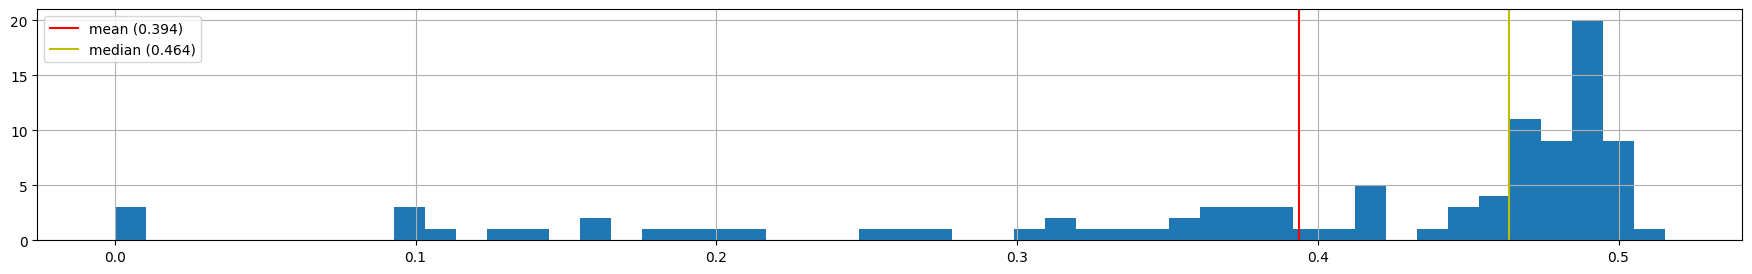

<Figure size 640x480 with 0 Axes>

In [417]:
plot_histogram(res_df['test_acc'], fig_size=(22, 3))

In [259]:
# median_acc = res_df['test_acc'].quantile(0.7)
# good_df = res_df.loc[res_df['test_acc'] >= median_acc]
# good_indice = list(good_df.index)
# good_df

In [260]:
# res_df['test_acc'].quantile(0.7)

## Concat results csvs

In [14]:
def parse_folder_arguments(folder_name):
    split_folder_name = folder_name.split('-')
    
    args_dict = {}
    args_dict['filter_method'] = split_folder_name[0]
    args_dict['acquisition'] = split_folder_name[1]
    
    for folder_substring in split_folder_name[2:]:
        if len(folder_substring) > 1:
            for i in range(1, len(folder_substring)):
                arg_name = folder_substring[:i]
                arg_value = folder_substring[i:]

                if not arg_name.isnumeric() and arg_value.isnumeric():
                    break
        elif folder_substring.isnumeric():
            arg_name = 'repetition'
            arg_value = folder_substring
                
        args_dict[arg_name] = int(arg_value)
        
    if not 'repetition' in args_dict:
        args_dict['repetition'] = 1
        
    return args_dict

In [15]:
experiment_types = sorted(list(os.listdir(experiments_path)))
print_indexed_list(experiment_types)

0 CIFAR-10-LeNet
1 MNIST-LeNet1
2 MNIST-LeNet2
3 custom


In [16]:
experiment_dataset_idx = 2

# experiment_dataset_path = path_join(experiments_path, experiment_types[experiment_dataset_idx], "min_agreggation-fix")
# experiment_dataset_path = path_join(experiments_path, experiment_types[experiment_dataset_idx], "topk")
# experiment_dataset_path = path_join(experiments_path, experiment_types[experiment_dataset_idx])
experiment_dataset_path = experiments_path
experiments = sorted(list(os.listdir(experiment_dataset_path)))
print_indexed_list(experiments)

0 CIFAR-10-LeNet
1 MNIST-LeNet1
2 MNIST-LeNet2
3 custom


In [17]:
result_dfs = []
experiment_index = 0

for root, subdirs, folder_contents in os.walk(experiment_dataset_path):
    if results_csv_name in folder_contents:
        subroot, folder_name = os.path.split(root)
        experiment_type = os.path.split(subroot)[1]
        
        args_dict = parse_folder_arguments(folder_name)
        
#         print(folder_name, folder_contents)
#         print(folder_name, args_dict)
        
        result_csv_name = path_join(root, results_csv_name)
        result_df = load_df(result_csv_name)
        
        result_df['experiment_type'] = experiment_type
        result_df['exp_index'] = experiment_index
        result_df['run_idx'] = result_df.index
        
        
        for arg_name, arg_value in args_dict.items():
            result_df[arg_name] = arg_value
            
        result_dfs.append(result_df)
        experiment_index += 1
        
#         display(result_df)
        
full_res_df = pd.concat(result_dfs)
full_res_df

Loaded a Dataframe with shape 20 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\max_agreggation\example_forgetting-ucb-k10-ff10-fq05\results.csv
at  2024-05-15 15:12:13.791710
Loaded a Dataframe with shape 20 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\max_agreggation\example_forgetting-ucb-k10-ff10-fq05-2\results.csv
at  2024-05-15 15:12:13.798712
Loaded a Dataframe with shape 20 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\max_agreggation\example_forgetting-ucb-k10-ff10-fq07\results.csv
at  2024-05-15 15:12:13.806209
Loaded a Dataframe with shape 20 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\max_agreggation\example_forgetting-ucb-k10-ff10-fq07-2\results.csv
at  2024-05-15 15:12:13.812210
Loaded a Dataframe with shape 20 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\ma

Loaded a Dataframe with shape 100 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\min_agreggation-fix\example_forgetting-ucb-k25-ftk2\results.csv
at  2024-05-15 15:12:14.178710
Loaded a Dataframe with shape 100 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\min_agreggation-fix\example_forgetting-ucb-k25-ftk2-2\results.csv
at  2024-05-15 15:12:14.196710
Loaded a Dataframe with shape 100 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\min_agreggation-fix\example_forgetting-ucb-k25-ftk3\results.csv
at  2024-05-15 15:12:14.213710
Loaded a Dataframe with shape 100 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\min_agreggation-fix\example_forgetting-ucb-k25-ftk5\results.csv
at  2024-05-15 15:12:14.231711
Loaded a Dataframe with shape 100 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\min

Loaded a Dataframe with shape 2 × 13 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\MNIST-LeNet1\frequency\example_forgetting-ucb-k25-ff10-fq07-2\results.csv
at  2024-05-15 15:12:14.561710
Loaded a Dataframe with shape 3 × 13 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\MNIST-LeNet1\frequency\example_forgetting-ucb-k25-ff3-fq05\results.csv
at  2024-05-15 15:12:14.566709
Loaded a Dataframe with shape 4 × 13 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\MNIST-LeNet1\frequency\example_forgetting-ucb-k25-ff3-fq05-2\results.csv
at  2024-05-15 15:12:14.570711
Loaded a Dataframe with shape 3 × 13 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\MNIST-LeNet1\frequency\example_forgetting-ucb-k25-ff5-fq05\results.csv
at  2024-05-15 15:12:14.574212
Loaded a Dataframe with shape 3 × 13 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\MNIST-LeNet1\frequency\example_forgetting-ucb-k25-ff5-fq0

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ff,fq,repetition,ftk,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.000131,0.561506,2.0,32,48,80.0,88.0,304,elu,BatchNorm,0.4340,0.4057,265.0,45000.0,max_agreggation,0,0,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.092518,0.699715,3.0,16,56,72.0,112.0,96,elu,Dropout,0.0000,0.0000,1.0,45000.0,max_agreggation,0,1,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001227,0.382351,3.0,24,48,88.0,88.0,304,elu,BatchNorm,0.4888,0.3770,330.0,45000.0,max_agreggation,0,2,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000100,1.000000,2.0,32,64,64.0,64.0,336,relu,None,0.5532,0.5262,199.0,45000.0,max_agreggation,0,3,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000100,1.000000,2.0,32,64,64.0,64.0,416,relu,None,0.5670,0.5307,208.0,45000.0,max_agreggation,0,4,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.003456,NaN,NaN,160,288,NaN,NaN,984,relu,NaN,0.9910,0.9827,61.0,2932.0,MNIST-LeNet2,132,95,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.275261,NaN,NaN,0.460564,NaN,NaN,NaN,Momentum,0.0,NaN
96,0.000164,NaN,NaN,152,264,NaN,NaN,984,elu,NaN,0.9858,0.9752,83.0,2932.0,MNIST-LeNet2,132,96,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.008180,NaN,NaN,0.740944,NaN,NaN,NaN,RMSProp,1.0,NaN
97,0.000740,NaN,NaN,128,224,NaN,NaN,704,tanh,NaN,0.1292,0.1293,8.0,2932.0,MNIST-LeNet2,132,97,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.708417,NaN,NaN,0.891251,NaN,NaN,NaN,Adam,1.0,NaN
98,0.000218,NaN,NaN,128,240,NaN,NaN,1008,lrelu,NaN,0.9974,0.9885,46.0,2932.0,MNIST-LeNet2,132,98,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.264997,NaN,NaN,0.697013,NaN,NaN,NaN,RMSProp,0.0,NaN


In [18]:
# result_dfs = []

# for task_name in os.listdir(experiments_path):
#     task_exps_path = path_join(experiments_path, task_name)
#     for experiment_name in os.listdir(task_exps_path):
        
#         args_dict = parse_folder_arguments(experiment_name)
        
#         if len(split_exp_name) > 2:
#             result_csv_name = path_join(task_exps_path, experiment_name, "results.csv")
            
#             if os.path.isfile(result_csv_name):
#                 result_df = load_df(result_csv_name)
                
#                 result_df['task'] = task_name
#                 result_df['parameter'] = split_exp_name[-2]
#                 result_df['num'] = split_exp_name[-1]
                
#                 result_dfs.append(result_df)
                
#             else:
#                 print("No result file in ", result_csv_name)
                
# #         elif "Stage" in experiment_name:
# #             for experiment_name in os.listdir(task_exps_path):
# #                 split_exp_name = experiment_name.split('-')

# #                 if len(split_exp_name) > 2:
# #                     result_csv_name = path_join(task_exps_path, experiment_name, "results.csv")

# #                     if os.path.isfile(result_csv_name):
# #                         result_df = load_df(result_csv_name)

# #                         result_df['task'] = task_name
# #                         result_df['parameter'] = split_exp_name[-2]
# #                         result_df['num'] = split_exp_name[-1]

# #                         result_dfs.append(result_df)

# #                     else:
# #                         print("No result file in ", result_csv_name)
            
# full_res_df = pd.concat(result_dfs)
# full_res_df

## Results csvs analysis

In [31]:
pd.value_counts(full_res_df['experiment_type'])

max_agreggation        612
min_agreggation-fix    600
MNIST-LeNet2           420
MNIST-LeNet1           390
min_agreggation        346
topk                   326
frequency              255
min_agreggation-2      199
LeNet2-Stage 1         110
LeNet1-Stage 1          80
Name: experiment_type, dtype: int64

In [34]:
full_res_df.replace({'experiment_type': {'max_agreggation': 'CIFAR-10', 'min_agreggation-fix': 'CIFAR-10', 'min_agreggation': 'CIFAR-10', 'min_agreggation-2': 'CIFAR-10', 
                                        'topk': 'MNIST-LeNet1', 'frequency': 'MNIST-LeNet1', 'LeNet1-Stage 1': 'MNIST-LeNet1', 'LeNet2-Stage 1': 'MNIST-LeNet2'}}, inplace=True)
pd.value_counts(full_res_df['experiment_type'])

CIFAR-10        1757
MNIST-LeNet1    1051
MNIST-LeNet2     530
Name: experiment_type, dtype: int64

In [35]:
full_res_df

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ff,fq,repetition,ftk,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.000131,0.561506,2.0,32,48,80.0,88.0,304,elu,BatchNorm,0.4340,0.4057,265.0,45000.0,CIFAR-10,0,0,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.092518,0.699715,3.0,16,56,72.0,112.0,96,elu,Dropout,0.0000,0.0000,1.0,45000.0,CIFAR-10,0,1,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001227,0.382351,3.0,24,48,88.0,88.0,304,elu,BatchNorm,0.4888,0.3770,330.0,45000.0,CIFAR-10,0,2,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000100,1.000000,2.0,32,64,64.0,64.0,336,relu,None,0.5532,0.5262,199.0,45000.0,CIFAR-10,0,3,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000100,1.000000,2.0,32,64,64.0,64.0,416,relu,None,0.5670,0.5307,208.0,45000.0,CIFAR-10,0,4,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.003456,NaN,NaN,160,288,NaN,NaN,984,relu,NaN,0.9910,0.9827,61.0,2932.0,MNIST-LeNet2,132,95,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.275261,NaN,NaN,0.460564,NaN,NaN,NaN,Momentum,0.0,NaN
96,0.000164,NaN,NaN,152,264,NaN,NaN,984,elu,NaN,0.9858,0.9752,83.0,2932.0,MNIST-LeNet2,132,96,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.008180,NaN,NaN,0.740944,NaN,NaN,NaN,RMSProp,1.0,NaN
97,0.000740,NaN,NaN,128,224,NaN,NaN,704,tanh,NaN,0.1292,0.1293,8.0,2932.0,MNIST-LeNet2,132,97,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.708417,NaN,NaN,0.891251,NaN,NaN,NaN,Adam,1.0,NaN
98,0.000218,NaN,NaN,128,240,NaN,NaN,1008,lrelu,NaN,0.9974,0.9885,46.0,2932.0,MNIST-LeNet2,132,98,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.264997,NaN,NaN,0.697013,NaN,NaN,NaN,RMSProp,0.0,NaN


In [36]:
full_res_df.sort_values('test_acc', ascending=False).head(60)

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ff,fq,repetition,ftk,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
6,0.001403,NaN,4.0,324,337,NaN,NaN,777,NaN,NaN,0.9998,0.9965,NaN,NaN,MNIST-LeNet1,62,6,MNIST,LeNet1,NaN,NaN,NaN,1,NaN,0.312840,3.0,3.0,0.348112,0.0,NaN,NaN,NaN,NaN,NaN
28,0.000226,NaN,8.0,291,153,NaN,NaN,598,NaN,NaN,0.9986,0.9962,NaN,NaN,MNIST-LeNet1,73,28,MNIST,LeNet1,NaN,NaN,NaN,5,NaN,0.662479,3.0,2.0,0.141773,NaN,5.0,NaN,NaN,NaN,NaN
26,0.000213,NaN,5.0,269,153,NaN,NaN,612,NaN,NaN,0.9988,0.9962,NaN,NaN,MNIST-LeNet1,72,26,MNIST,LeNet1,NaN,NaN,NaN,3,NaN,0.227679,3.0,2.0,0.228470,NaN,5.0,NaN,NaN,NaN,NaN
21,0.000543,NaN,8.0,211,14,NaN,NaN,480,NaN,NaN,1.0000,0.9961,NaN,NaN,MNIST-LeNet1,68,21,MNIST,LeNet1,NaN,NaN,NaN,4,NaN,0.544207,2.0,2.0,0.560839,0.0,NaN,NaN,NaN,NaN,NaN
12,0.001004,NaN,5.0,277,152,NaN,NaN,596,NaN,NaN,1.0000,0.9961,NaN,NaN,MNIST-LeNet1,67,12,MNIST,LeNet1,NaN,NaN,NaN,3,NaN,0.131832,3.0,3.0,0.351791,0.0,NaN,NaN,NaN,NaN,NaN
20,0.000916,NaN,7.0,290,158,NaN,NaN,599,NaN,NaN,1.0000,0.9961,NaN,NaN,MNIST-LeNet1,77,20,MNIST,LeNet1,NaN,NaN,NaN,3,NaN,0.475490,2.0,2.0,0.489936,NaN,NaN,0.0,NaN,NaN,NaN
2,0.000452,NaN,7.0,200,272,NaN,NaN,792,NaN,NaN,1.0000,0.9961,850.0,55000.0,MNIST-LeNet1,116,2,example_forgetting,ucb,40.0,5.0,7.0,1,NaN,0.072416,2.0,2.0,0.238129,NaN,NaN,NaN,NaN,NaN,NaN
5,0.001024,NaN,9.0,248,224,NaN,NaN,392,NaN,NaN,1.0000,0.9961,711.0,55000.0,MNIST-LeNet1,125,5,example_forgetting,ucb,25.0,NaN,NaN,1,5.0,0.732406,2.0,3.0,0.256919,NaN,NaN,NaN,NaN,NaN,NaN
8,0.000284,NaN,9.0,214,17,NaN,NaN,483,NaN,NaN,0.9996,0.9961,NaN,NaN,MNIST-LeNet1,64,8,MNIST,LeNet1,NaN,NaN,NaN,2,NaN,0.840173,2.0,2.0,0.392572,NaN,5.0,NaN,NaN,NaN,NaN
8,0.000284,NaN,9.0,214,17,NaN,NaN,483,NaN,NaN,0.9984,0.9960,NaN,NaN,MNIST-LeNet1,72,8,MNIST,LeNet1,NaN,NaN,NaN,3,NaN,0.840173,2.0,2.0,0.392572,NaN,5.0,NaN,NaN,NaN,NaN


In [21]:
plot_scatter_historgram(full_res_df['time_spent'], full_res_df['test_acc'])

ValueError: autodetected range of [nan, nan] is not finite

In [23]:
fit_res_df = full_res_df.loc[full_res_df['test_acc'] > 0.011]
fit_res_df

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ff,fq,repetition,ftk,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.000131,0.561506,2.0,32,48,80.0,88.0,304,elu,BatchNorm,0.4340,0.4057,265.0,45000.0,max_agreggation,0,0,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001227,0.382351,3.0,24,48,88.0,88.0,304,elu,BatchNorm,0.4888,0.3770,330.0,45000.0,max_agreggation,0,2,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000100,1.000000,2.0,32,64,64.0,64.0,336,relu,None,0.5532,0.5262,199.0,45000.0,max_agreggation,0,3,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000100,1.000000,2.0,32,64,64.0,64.0,416,relu,None,0.5670,0.5307,208.0,45000.0,max_agreggation,0,4,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000100,1.000000,2.0,32,64,64.0,64.0,560,relu,None,0.5660,0.5239,228.0,45000.0,max_agreggation,0,5,example_forgetting,ucb,10.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.003456,NaN,NaN,160,288,NaN,NaN,984,relu,NaN,0.9910,0.9827,61.0,2932.0,MNIST-LeNet2,132,95,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.275261,NaN,NaN,0.460564,NaN,NaN,NaN,Momentum,0.0,NaN
96,0.000164,NaN,NaN,152,264,NaN,NaN,984,elu,NaN,0.9858,0.9752,83.0,2932.0,MNIST-LeNet2,132,96,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.008180,NaN,NaN,0.740944,NaN,NaN,NaN,RMSProp,1.0,NaN
97,0.000740,NaN,NaN,128,224,NaN,NaN,704,tanh,NaN,0.1292,0.1293,8.0,2932.0,MNIST-LeNet2,132,97,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.708417,NaN,NaN,0.891251,NaN,NaN,NaN,Adam,1.0,NaN
98,0.000218,NaN,NaN,128,240,NaN,NaN,1008,lrelu,NaN,0.9974,0.9885,46.0,2932.0,MNIST-LeNet2,132,98,example_forgetting,ucb,40.0,NaN,NaN,1,5.0,0.264997,NaN,NaN,0.697013,NaN,NaN,NaN,RMSProp,0.0,NaN


In [24]:
# full_res_df.loc[full_res_df['test_acc'] <= 0.1012]

In [25]:
fit_res_df.corr()

<ipython-input-25-01e92ac64854>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  fit_res_df.corr()


,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,val_acc,test_acc,time_spent,train_set_size,exp_index,run_idx,k,ff,fq,repetition,ftk,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,batch_normalization,50
learning_rate,1.000000,0.056072,-0.102848,-0.087222,-0.048373,0.009417,0.047056,0.058952,-0.254219,-0.237385,0.048761,0.125759,-0.108744,-0.075424,0.067941,-0.000231,-0.078889,0.032398,-0.150367,0.008931,0.062693,-0.071240,0.084023,NaN,NaN,NaN,0.169064,NaN
l2_reg,0.056072,1.000000,0.004977,-0.001920,0.044569,-0.022126,-0.029892,0.071733,-0.050011,-0.065083,-0.033399,0.011239,-0.044364,0.028088,-0.060812,0.080050,0.032881,0.016590,-0.035806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
window_size,-0.102848,0.004977,1.000000,0.533676,0.373734,-0.031424,0.009674,-0.032907,0.079255,0.253060,-0.215131,-0.260813,0.582310,-0.142801,-0.079732,0.142894,0.027725,0.263223,0.550306,0.081624,0.106743,-0.107685,0.145951,NaN,NaN,NaN,NaN,NaN
conv1_depth,-0.087222,-0.001920,0.533676,1.000000,0.453894,-0.023455,0.049102,0.164221,0.129166,0.303774,-0.237027,-0.382070,0.502788,-0.067688,0.051632,0.154874,0.099575,0.339236,0.263295,-0.008287,0.058873,0.114105,-0.096778,NaN,NaN,NaN,-0.053655,NaN
conv2_depth,-0.048373,0.044569,0.373734,0.453894,1.000000,0.023303,-0.060536,0.109815,0.134035,0.289036,-0.269740,-0.431186,0.558642,-0.006600,0.115052,0.203317,0.130660,0.107985,0.308069,-0.072954,0.080231,0.148854,-0.044590,NaN,NaN,NaN,0.025850,NaN
conv3_depth,0.009417,-0.022126,-0.031424,-0.023455,0.023303,1.000000,0.108133,0.064347,-0.013896,-0.036094,0.116380,0.046489,-0.011189,-0.011750,0.033605,-0.080331,-0.047557,0.018534,-0.080278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conv4_depth,0.047056,-0.029892,0.009674,0.049102,-0.060536,0.108133,1.000000,-0.057128,-0.038834,-0.049221,0.107804,0.029510,0.098091,0.038953,0.123226,-0.103654,-0.067651,-0.065245,-0.007566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fc_depth,0.058952,0.071733,-0.032907,0.164221,0.109815,0.064347,-0.057128,1.000000,0.009087,0.036716,0.157682,-0.080841,0.046788,0.015010,0.013458,0.099239,0.020510,0.063972,-0.043587,-0.025667,0.055359,-0.005610,-0.086570,NaN,NaN,NaN,-0.011105,NaN
val_acc,-0.254219,-0.050011,0.079255,0.129166,0.134035,-0.013896,-0.038834,0.009087,1.000000,0.928203,0.142467,-0.015236,0.126684,0.015773,-0.019043,0.028139,0.050946,-0.075588,0.033907,-0.041464,0.010735,0.030003,0.111867,NaN,NaN,NaN,0.126989,NaN
test_acc,-0.237385,-0.065083,0.253060,0.303774,0.289036,-0.036094,-0.049221,0.036716,0.928203,1.000000,-0.007956,-0.176094,0.332787,0.008710,0.056819,0.101583,0.049890,-0.030284,0.151777,-0.040877,0.010199,0.030514,0.110601,NaN,NaN,NaN,0.124235,NaN


In [26]:
plot_scatter_historgram(full_res_df['train_set_size'], full_res_df['test_acc'])

ValueError: autodetected range of [nan, nan] is not finite

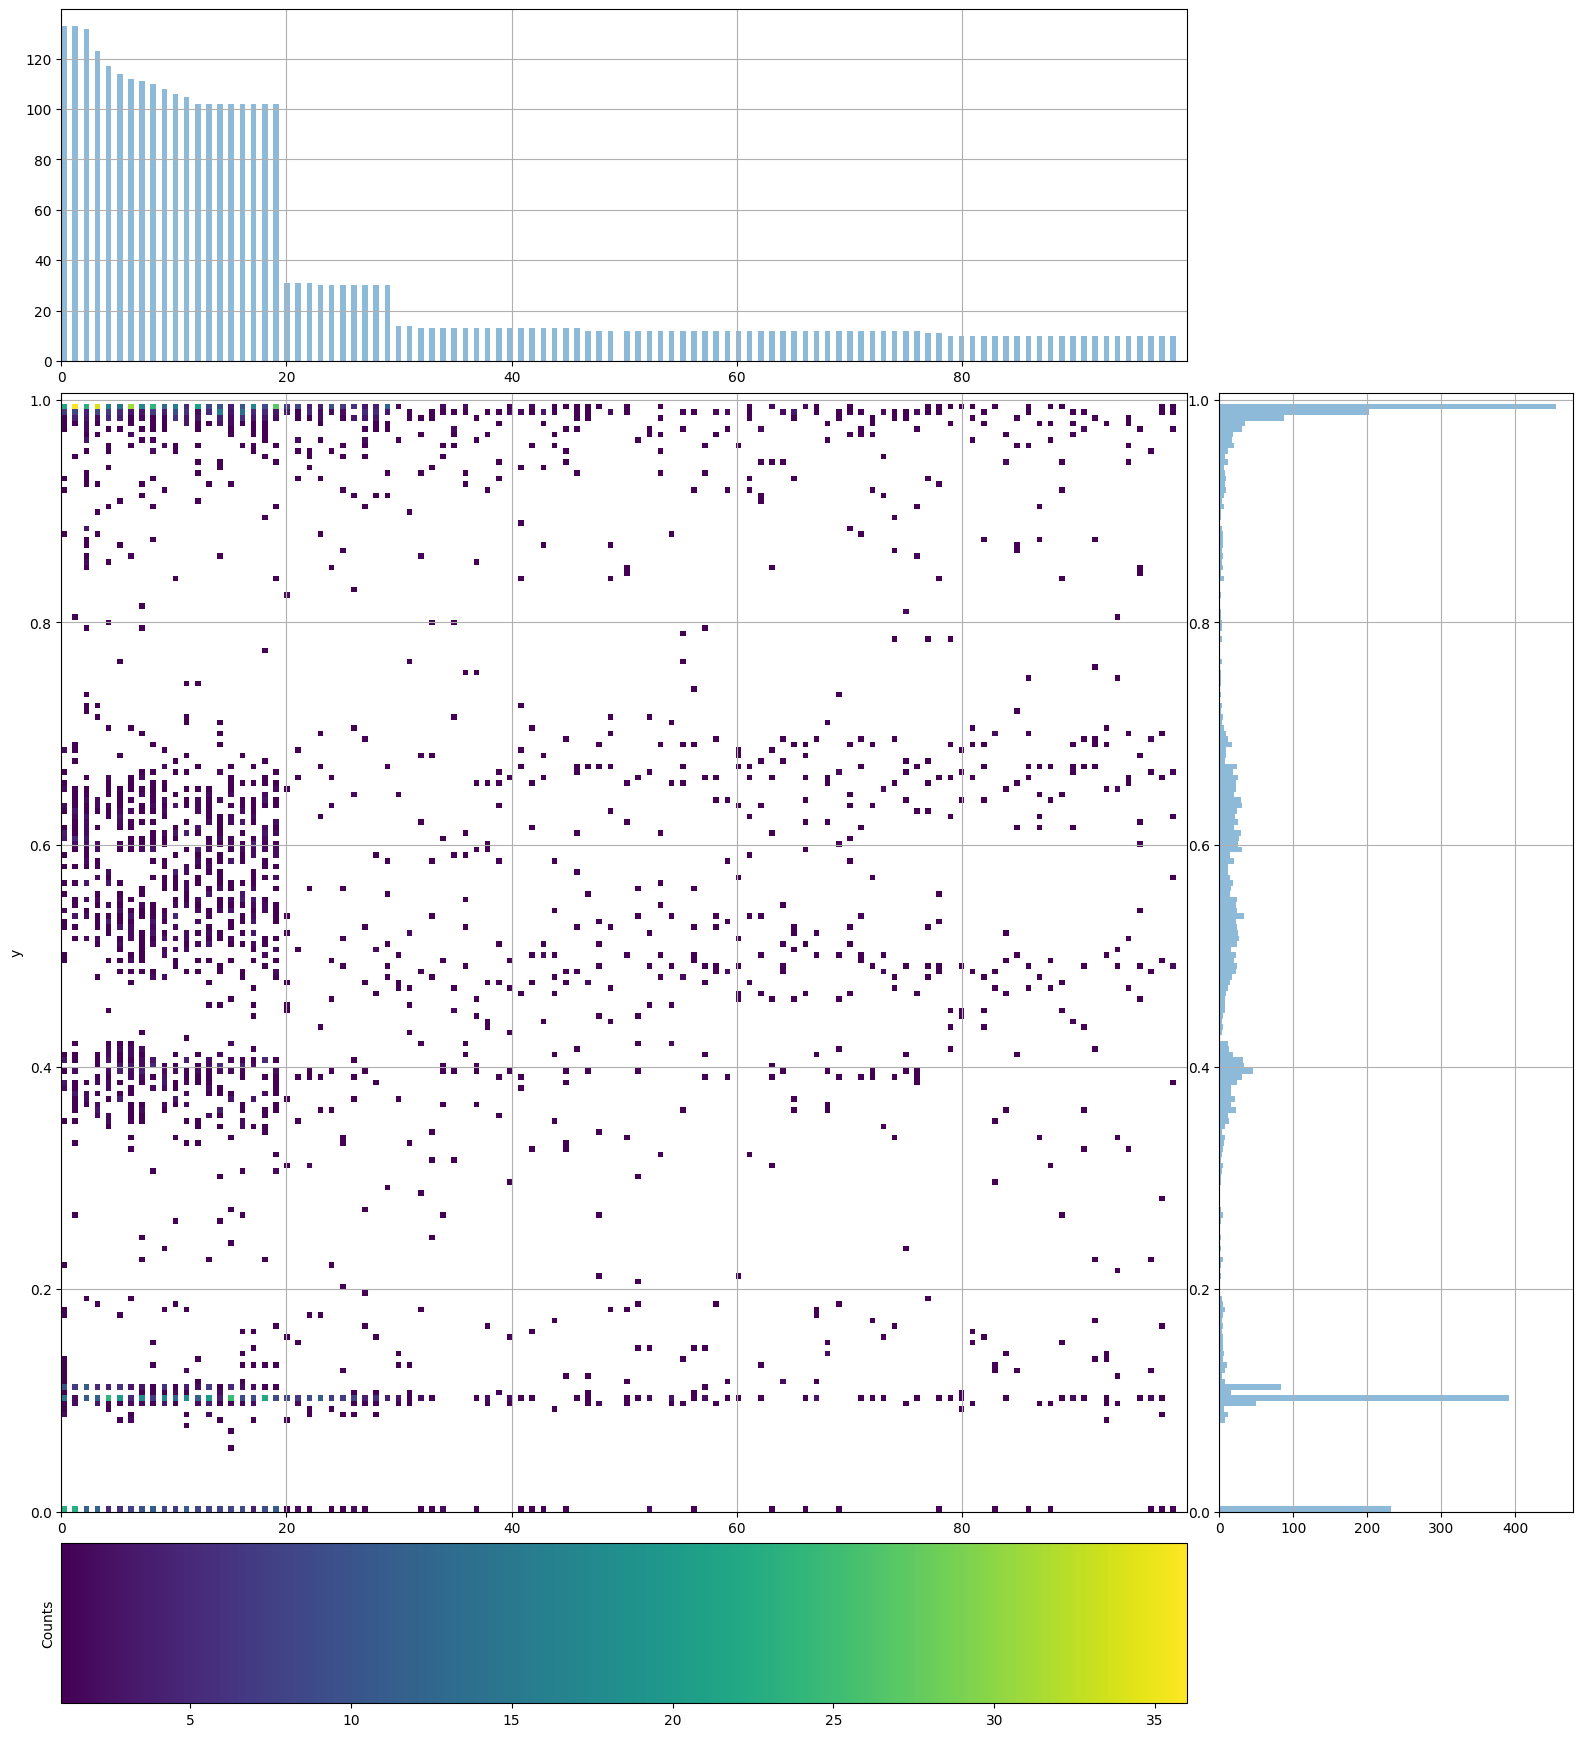

<Figure size 640x480 with 0 Axes>

In [27]:
plot_scatter_historgram(full_res_df['run_idx'], full_res_df['test_acc'])

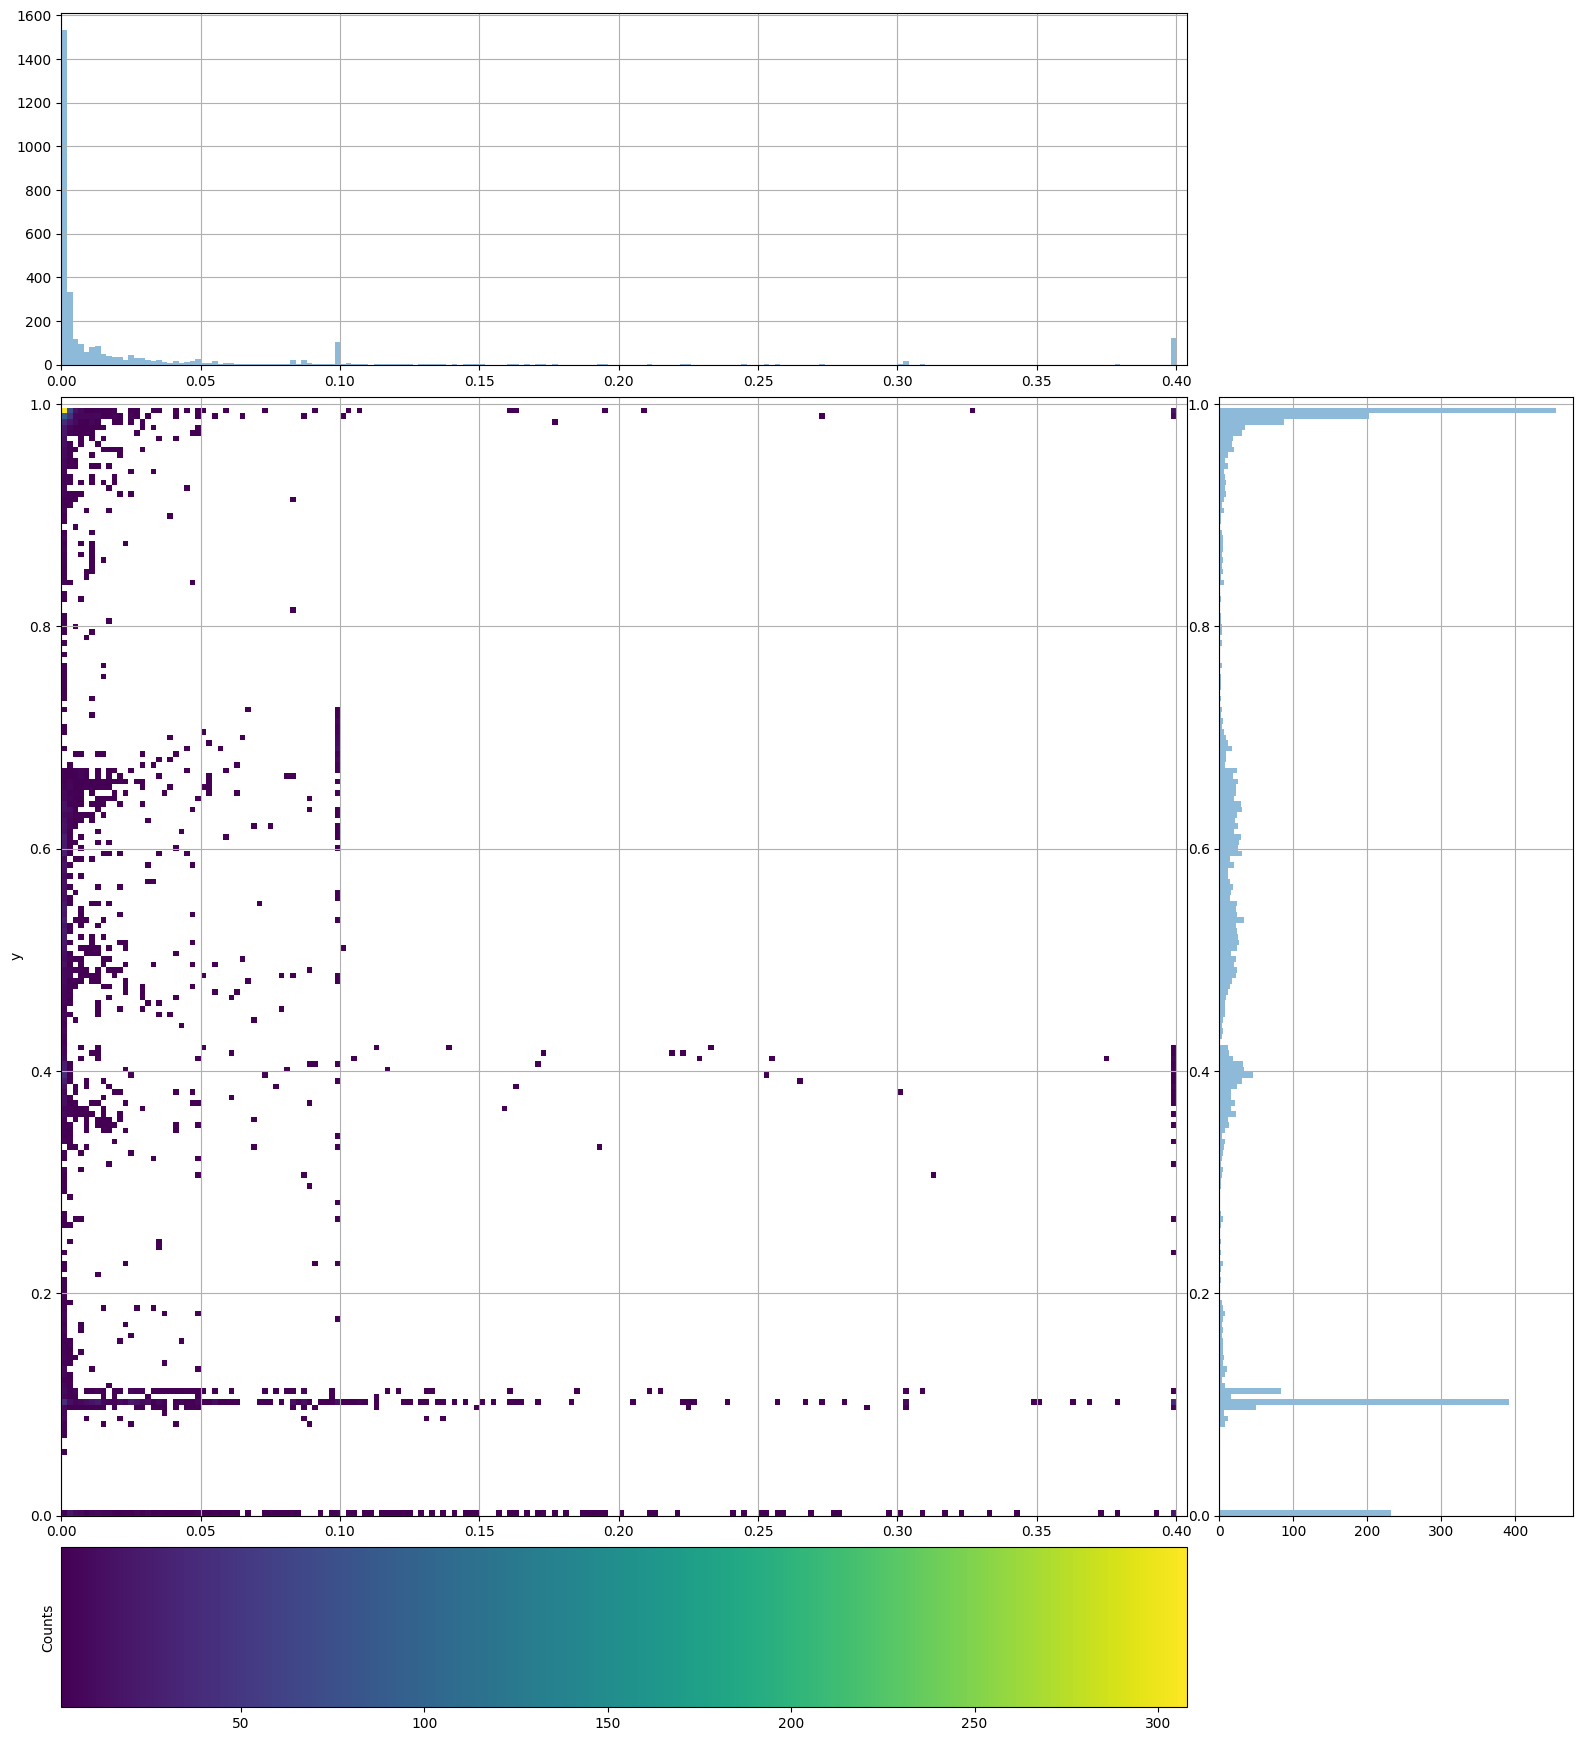

<Figure size 640x480 with 0 Axes>

In [28]:
plot_scatter_historgram(full_res_df['learning_rate'], full_res_df['test_acc'])

In [29]:
full_res_df.loc[full_res_df['train_set_size'] == 0]

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ff,fq,repetition,ftk,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
3,0.000167,0.097403,2.0,24,64,96.0,128.0,928,tanh,None,0.0942,0.1002,42.0,0.0,min_agreggation-2,51,3,example_forgetting,ucb,25.0,3.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.001860,0.000872,2.0,24,48,96.0,88.0,856,elu,Dropout,0.0954,0.0910,22.0,0.0,min_agreggation-2,51,4,example_forgetting,ucb,25.0,3.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.014702,0.963886,3.0,32,32,80.0,72.0,760,elu,BatchNorm,0.0806,0.0835,14.0,0.0,min_agreggation-2,51,5,example_forgetting,ucb,25.0,3.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.000140,0.341959,3.0,8,56,96.0,96.0,32,relu,None,0.0834,0.0813,4.0,0.0,min_agreggation-2,51,6,example_forgetting,ucb,25.0,3.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.000607,0.411253,2.0,16,40,104.0,120.0,344,relu,Dropout,0.0960,0.1009,18.0,0.0,min_agreggation-2,51,7,example_forgetting,ucb,25.0,3.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.020067,0.673930,3.0,8,56,112.0,88.0,80,tanh,BatchNorm,0.1086,0.1060,6.0,0.0,min_agreggation-2,51,8,example_forgetting,ucb,25.0,3.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.000973,0.452633,3.0,32,40,72.0,112.0,528,elu,None,0.1070,0.1046,8.0,0.0,min_agreggation-2,51,9,example_forgetting,ucb,25.0,3.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.005199,0.215228,3.0,24,56,88.0,104.0,192,elu,Dropout,0.1062,0.1066,7.0,0.0,min_agreggation-2,51,10,example_forgetting,ucb,25.0,3.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.000607,0.787657,3.0,16,32,72.0,72.0,424,relu,None,0.0792,0.0771,10.0,0.0,min_agreggation-2,51,11,example_forgetting,ucb,25.0,3.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.000142,0.241169,3.0,16,64,88.0,80.0,632,tanh,BatchNorm,0.1048,0.1002,8.0,0.0,min_agreggation-2,51,12,example_forgetting,ucb,25.0,3.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Depreciated, use calculate_CED
k=10.0 | size: 546 | test_acc: 0.4882
Depreciated, use calculate_CED
k=25.0 | size: 993 | test_acc: 0.4729
Depreciated, use calculate_CED
k=40.0 | size: 1099 | test_acc: 0.5559


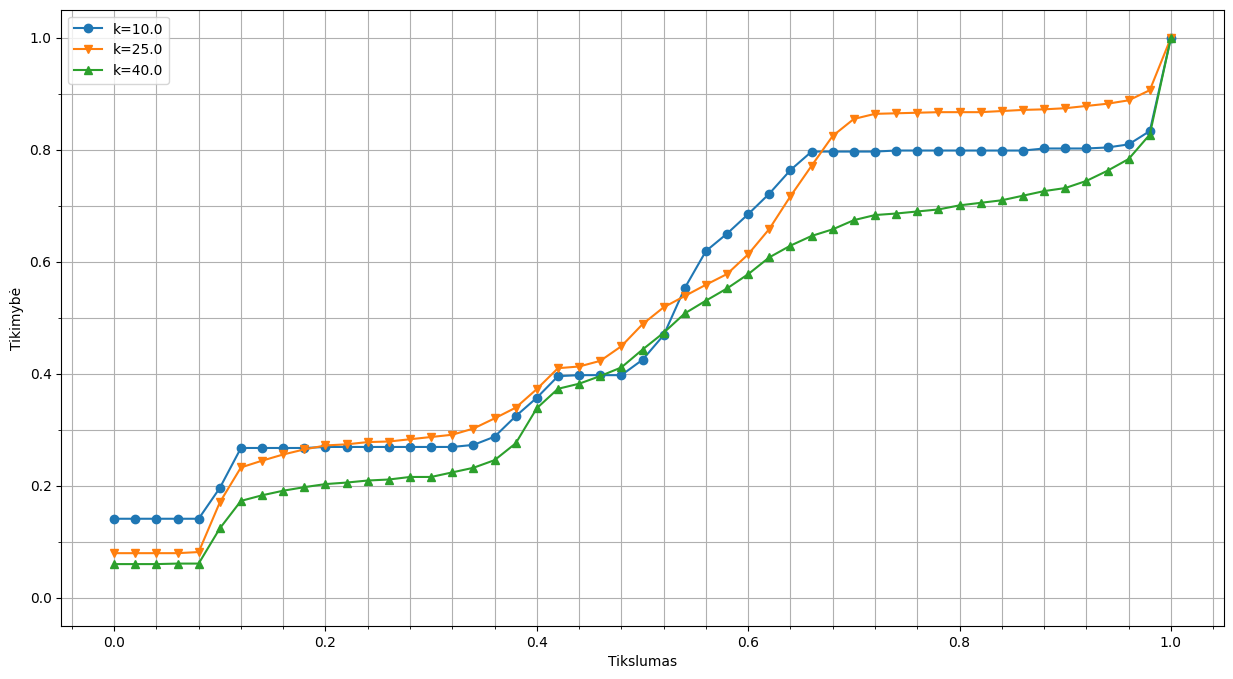

{10.0: 0.4881847985347985, 25.0: 0.4728966767371601, 40.0: 0.5559204731574158}

<Figure size 640x480 with 0 Axes>

In [53]:
categorical_metric_analysis(full_res_df, ['k'], 'test_acc', True, (15, 8))

ftk=2 | size: 100 | test_acc: 0.8123
ftk=3 | size: 100 | test_acc: 0.7557
ftk=5 | size: 44 | test_acc: 0.6236


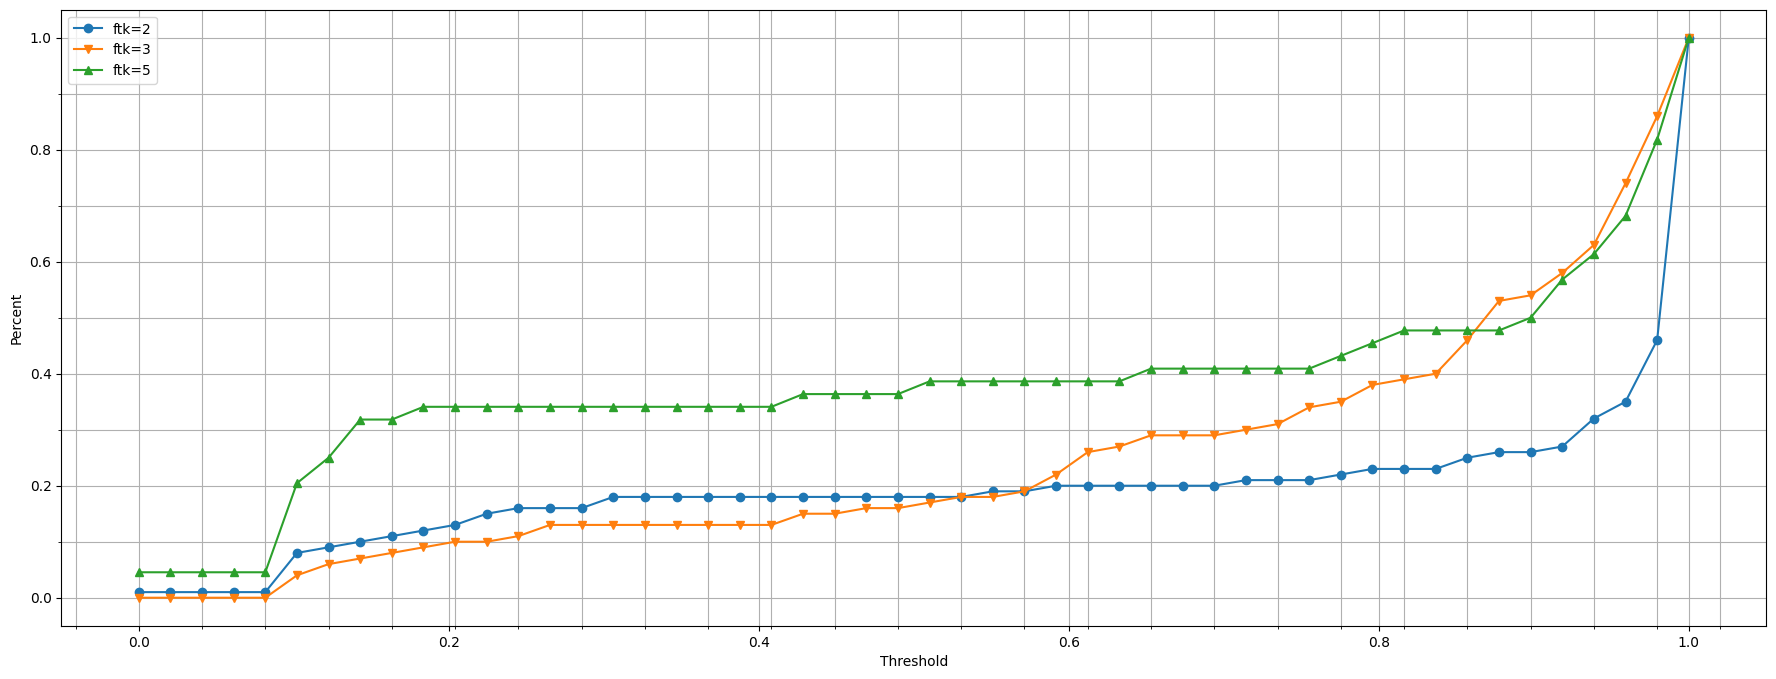

{2: 0.812262, 3: 0.7556510000000003, 5: 0.6236250000000001}

<Figure size 640x480 with 0 Axes>

In [362]:
categorical_metric_analysis(full_res_df, ['ftk'], 'test_acc', True)

run_idx=0 | size:  3 | test_acc: 0.9909
run_idx=1 | size:  3 | test_acc: 0.9871
run_idx=2 | size:  3 | test_acc: 0.9838
run_idx=3 | size:  3 | test_acc: 0.9850
run_idx=4 | size:  3 | test_acc: 0.8964
run_idx=5 | size:  3 | test_acc: 0.6484
run_idx=6 | size:  3 | test_acc: 0.6503
run_idx=7 | size:  3 | test_acc: 0.3758
run_idx=8 | size:  3 | test_acc: 0.6749
run_idx=9 | size:  3 | test_acc: 0.6671
run_idx=10 | size:  3 | test_acc: 0.6800
run_idx=11 | size:  3 | test_acc: 0.1325
run_idx=12 | size:  3 | test_acc: 0.9428
run_idx=13 | size:  3 | test_acc: 0.6726
run_idx=14 | size:  3 | test_acc: 0.7153
run_idx=15 | size:  3 | test_acc: 0.4400
run_idx=16 | size:  3 | test_acc: 0.4664
run_idx=17 | size:  3 | test_acc: 0.6951
run_idx=18 | size:  3 | test_acc: 0.9171
run_idx=19 | size:  3 | test_acc: 0.9371
run_idx=20 | size:  3 | test_acc: 0.4421
run_idx=21 | size:  3 | test_acc: 0.6614
run_idx=22 | size:  3 | test_acc: 0.6765
run_idx=23 | size:  3 | test_acc: 0.9660
run_idx=24 | size:  3 | te

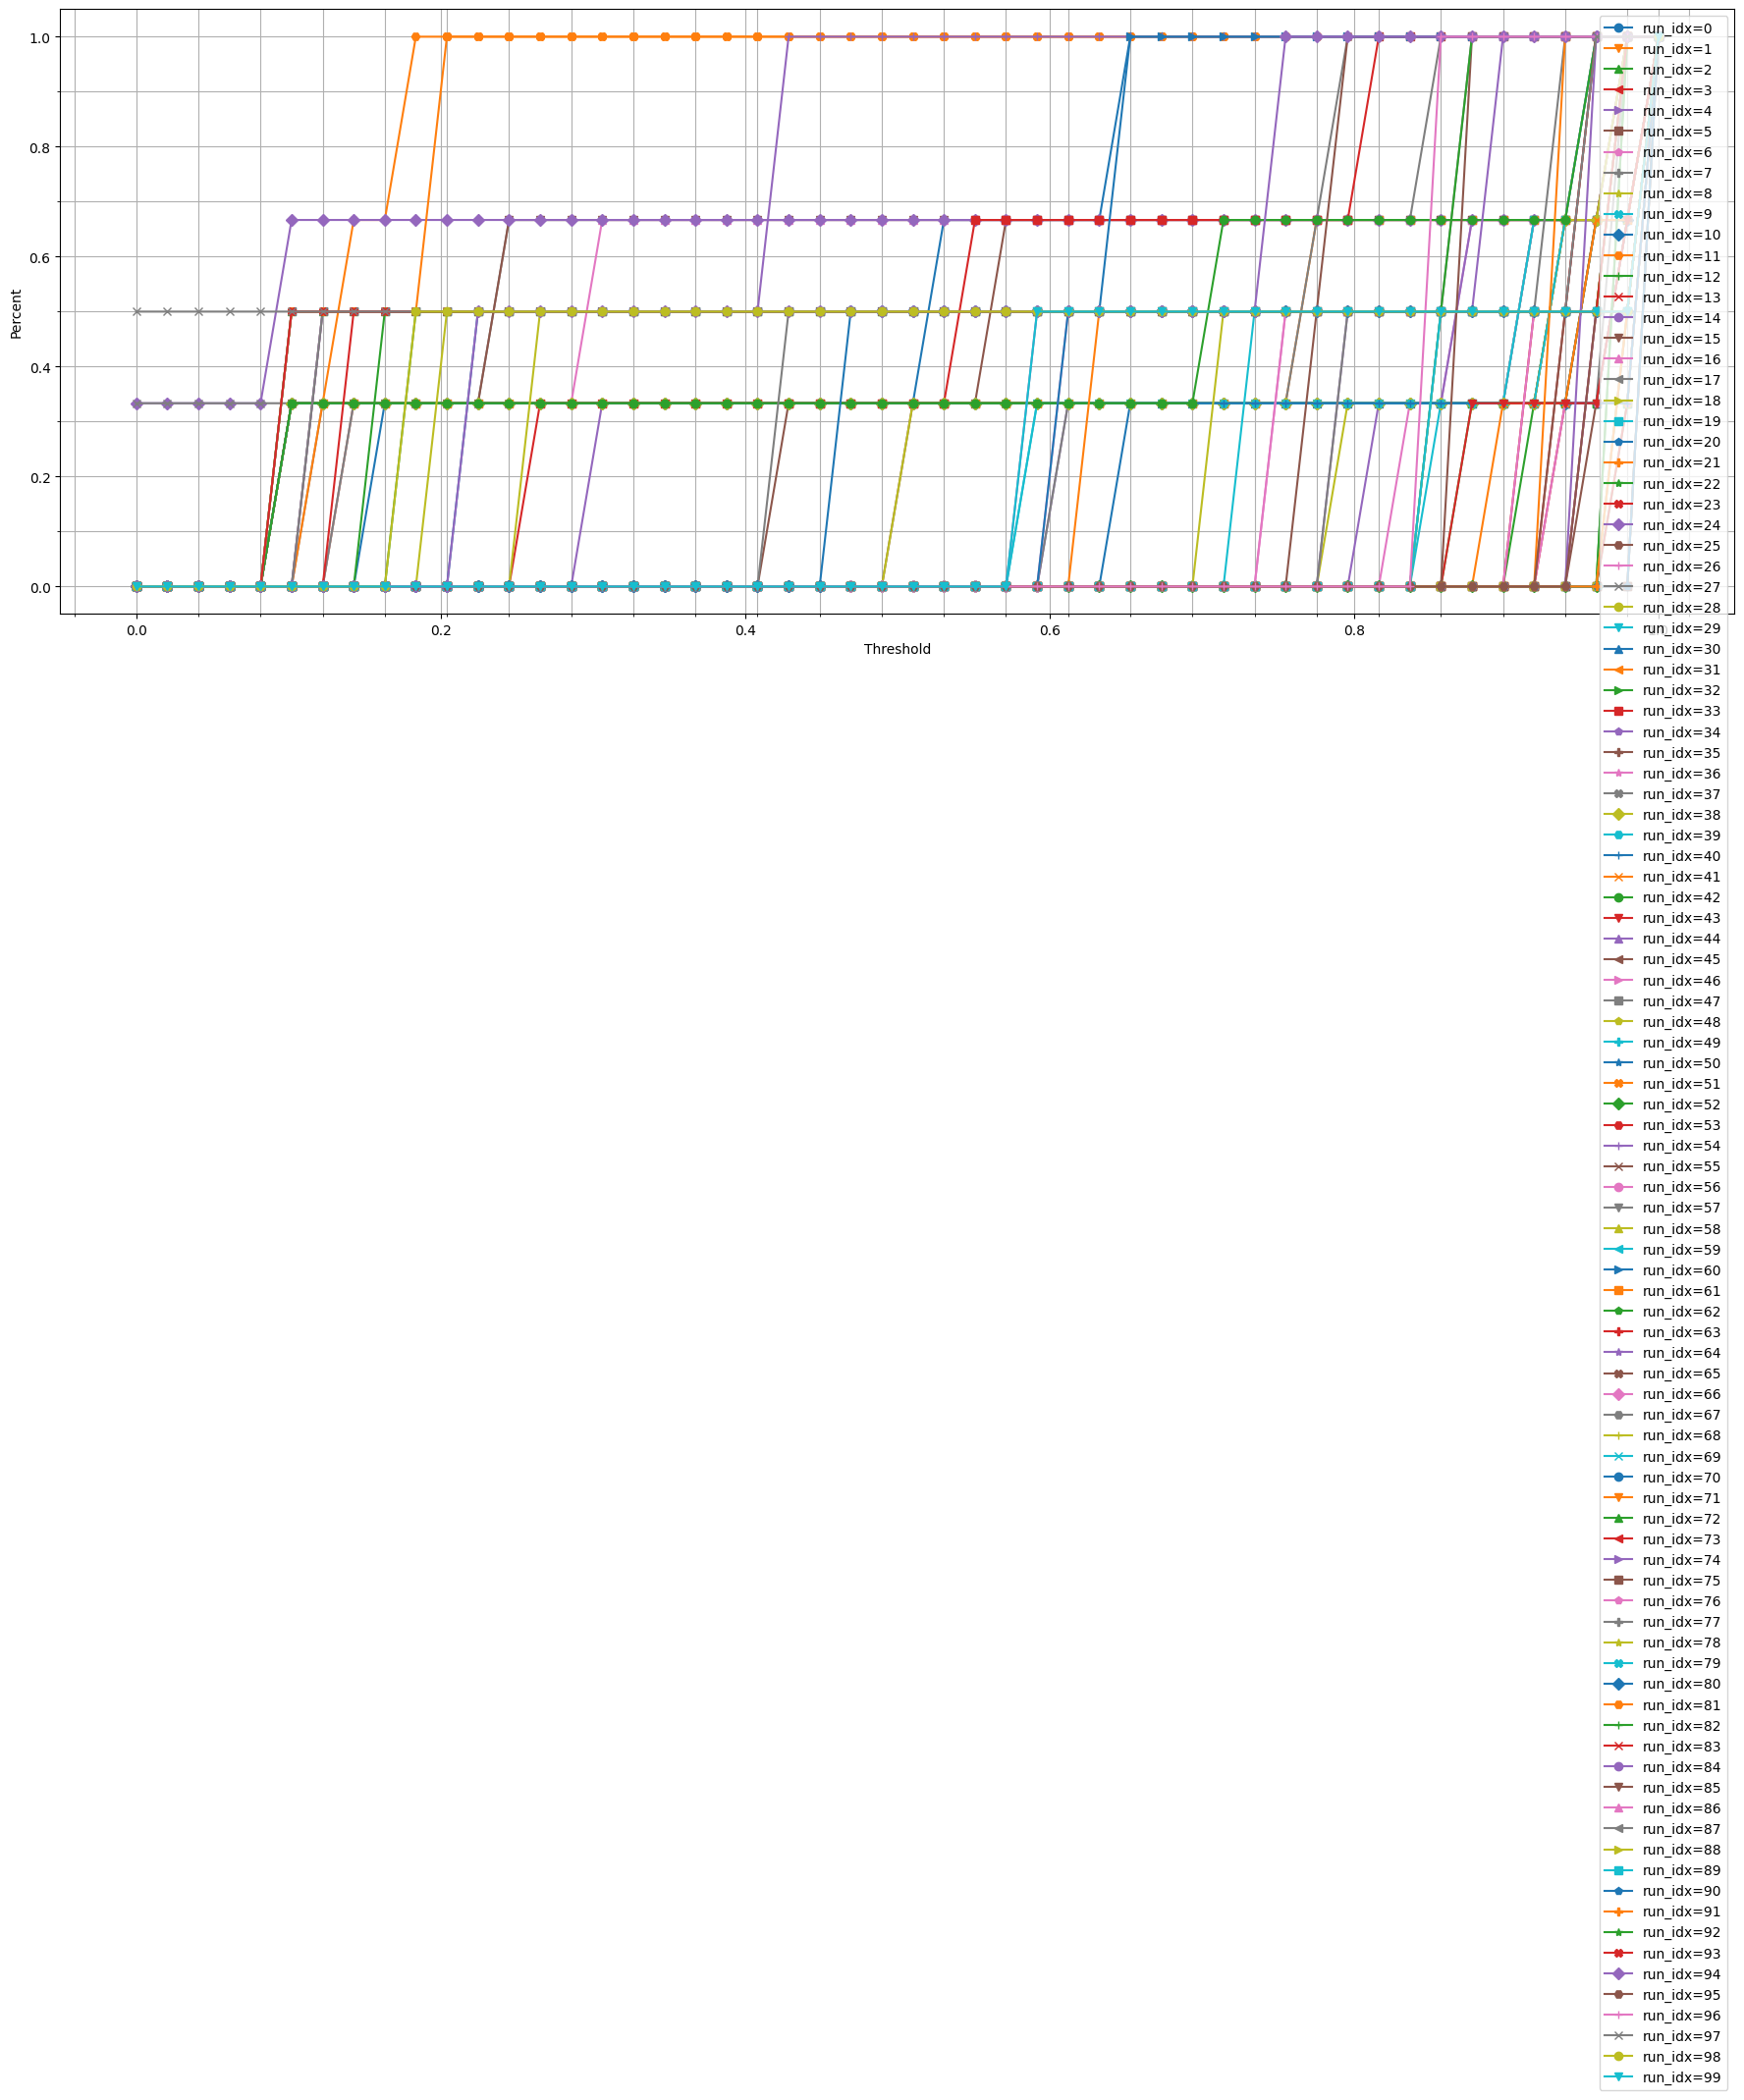

<Figure size 640x480 with 0 Axes>

In [363]:
categorical_accuracies = categorical_metric_analysis(full_res_df, ['run_idx'], 'test_acc', True)

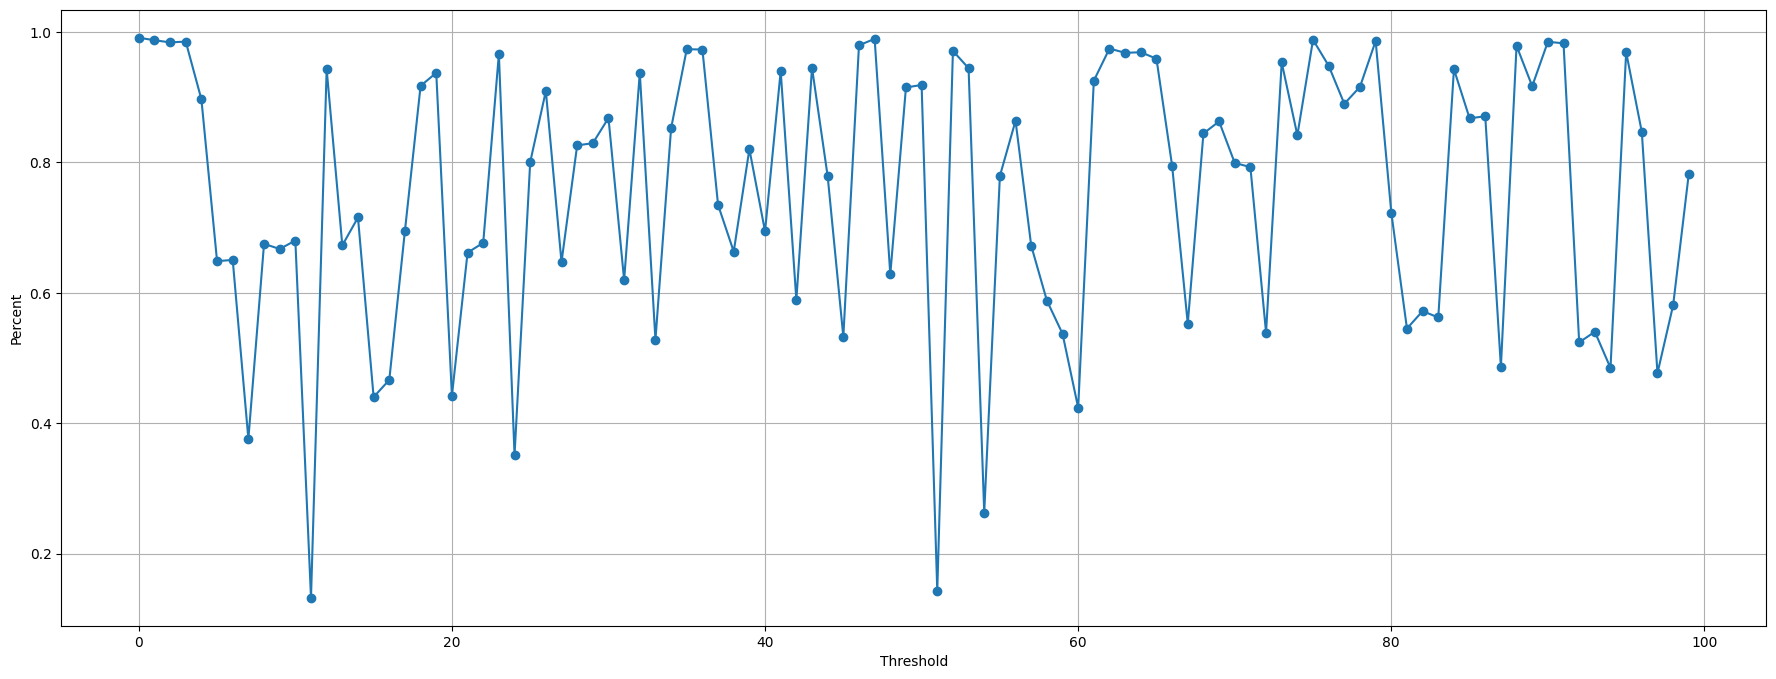

<Figure size 640x480 with 0 Axes>

In [354]:
plot_xy_curves(list(categorical_accuracies.keys()), [list(categorical_accuracies.values())])

In [336]:
fit_res_df

,learning_rate,reg_param,conv1_depth,pool1_size,conv2_depth,pool2_size,window_size,fc_depth,dropout_rate,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition
0,0.049704,0.233068,112,3,80,2,8,856,0.565574,0.1068,0.1135,34,55000,topk,0,0,example_forgetting,ucb,10,10,1
1,0.025115,0.440977,216,3,64,2,8,808,0.043545,0.1068,0.1135,52,55000,topk,0,1,example_forgetting,ucb,10,10,1
2,0.000789,0.521409,328,3,320,2,9,8,0.821616,0.9986,0.9872,628,55000,topk,0,2,example_forgetting,ucb,10,10,1
3,0.001145,0.866528,320,3,296,3,9,16,0.588942,1.0000,0.9940,503,55000,topk,0,3,example_forgetting,ucb,10,10,1
0,0.038354,0.722670,16,2,328,2,8,696,0.114607,0.1068,0.1135,65,55000,topk,1,0,example_forgetting,ucb,10,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,0.000498,0.531366,88,2,224,3,7,312,0.427875,0.9972,0.9932,28,2897,topk,10,21,example_forgetting,ucb,40,3,1
22,0.000598,0.222070,64,2,208,2,4,336,0.900000,0.9982,0.9904,17,2897,topk,10,22,example_forgetting,ucb,40,3,1
0,0.007693,0.563896,160,2,136,3,4,248,0.036983,0.5138,0.5408,161,55000,topk,11,0,example_forgetting,ucb,40,5,1
1,0.008767,0.817292,240,2,120,3,5,504,0.199181,0.9910,0.9898,214,55000,topk,11,1,example_forgetting,ucb,40,5,1


In [364]:
fit_res_df.sort_values('test_acc', ascending=False).head(3)['test_acc'].index.to_list()

[0, 3, 6]

### Check for duplicated architectures

In [365]:
full_res_df

,learning_rate,reg_param,dropout_rate,conv1_depth,conv2_depth,fc_depth,activation,optimizer,batch_normalization,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition
0,0.007476,0.815834,0.576669,344,80,696,elu,GD,0,0.9884,0.9866,412,55000,MNIST-LeNet2,0,0,example_forgetting,ucb,40,2,1
1,0.001193,0.962770,0.687991,216,8,752,elu,Momentum,0,0.9860,0.9836,186,55000,MNIST-LeNet2,0,1,example_forgetting,ucb,40,2,1
2,0.000903,0.011559,0.276761,336,72,688,lrelu,AdaDelta,1,0.9660,0.9659,555,55000,MNIST-LeNet2,0,2,example_forgetting,ucb,40,2,1
3,0.003949,0.729768,0.868007,72,216,80,lrelu,Adam,0,0.9994,0.9942,95,17070,MNIST-LeNet2,0,3,example_forgetting,ucb,40,2,1
4,0.020007,0.056535,0.211108,192,56,544,elu,Adam,1,0.9880,0.9853,37,18819,MNIST-LeNet2,0,4,example_forgetting,ucb,40,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,0.003056,1.000000,0.900000,120,168,688,lrelu,Momentum,0,0.9482,0.9460,51,2930,MNIST-LeNet2,2,39,example_forgetting,ucb,40,5,1
40,0.000309,0.566775,0.611626,160,280,1024,sigmoid,Adam,1,0.1042,0.1010,612,2930,MNIST-LeNet2,2,40,example_forgetting,ucb,40,5,1
41,0.005823,0.694865,0.692609,192,288,952,elu,AdaDelta,0,0.8902,0.8884,108,2930,MNIST-LeNet2,2,41,example_forgetting,ucb,40,5,1
42,0.001338,0.953520,0.593081,200,288,944,sigmoid,RMSProp,0,0.0956,0.1009,79,2930,MNIST-LeNet2,2,42,example_forgetting,ucb,40,5,1


In [368]:
float_columns = ['learning_rate', 'l2_reg']

rounded_full_res_df = full_res_df.copy()  # full_res_df.drop(columns=full_res_df.columns[10:])
rounded_full_res_df['learning_rate'] = np.round(rounded_full_res_df['learning_rate'], 3)
# rounded_full_res_df['l2_reg'] = np.round(rounded_full_res_df['l2_reg'], 2)
rounded_full_res_df

,learning_rate,reg_param,dropout_rate,conv1_depth,conv2_depth,fc_depth,activation,optimizer,batch_normalization,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition
0,0.007,0.815834,0.576669,344,80,696,elu,GD,0,0.9884,0.9866,412,55000,MNIST-LeNet2,0,0,example_forgetting,ucb,40,2,1
1,0.001,0.962770,0.687991,216,8,752,elu,Momentum,0,0.9860,0.9836,186,55000,MNIST-LeNet2,0,1,example_forgetting,ucb,40,2,1
2,0.001,0.011559,0.276761,336,72,688,lrelu,AdaDelta,1,0.9660,0.9659,555,55000,MNIST-LeNet2,0,2,example_forgetting,ucb,40,2,1
3,0.004,0.729768,0.868007,72,216,80,lrelu,Adam,0,0.9994,0.9942,95,17070,MNIST-LeNet2,0,3,example_forgetting,ucb,40,2,1
4,0.020,0.056535,0.211108,192,56,544,elu,Adam,1,0.9880,0.9853,37,18819,MNIST-LeNet2,0,4,example_forgetting,ucb,40,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,0.003,1.000000,0.900000,120,168,688,lrelu,Momentum,0,0.9482,0.9460,51,2930,MNIST-LeNet2,2,39,example_forgetting,ucb,40,5,1
40,0.000,0.566775,0.611626,160,280,1024,sigmoid,Adam,1,0.1042,0.1010,612,2930,MNIST-LeNet2,2,40,example_forgetting,ucb,40,5,1
41,0.006,0.694865,0.692609,192,288,952,elu,AdaDelta,0,0.8902,0.8884,108,2930,MNIST-LeNet2,2,41,example_forgetting,ucb,40,5,1
42,0.001,0.953520,0.593081,200,288,944,sigmoid,RMSProp,0,0.0956,0.1009,79,2930,MNIST-LeNet2,2,42,example_forgetting,ucb,40,5,1


learning_rate=0.0 | size: 59 | test_acc: 0.7209
learning_rate=0.001 | size: 46 | test_acc: 0.8340
learning_rate=0.002 | size: 21 | test_acc: 0.8416
learning_rate=0.003 | size: 13 | test_acc: 0.7276
learning_rate=0.004 | size:  9 | test_acc: 0.7659
learning_rate=0.005 | size:  9 | test_acc: 0.9662
learning_rate=0.006 | size:  4 | test_acc: 0.7487
learning_rate=0.007 | size:  6 | test_acc: 0.8234
learning_rate=0.008 | size:  5 | test_acc: 0.8063
learning_rate=0.009 | size:  2 | test_acc: 0.9799
learning_rate=0.01 | size:  6 | test_acc: 0.6019
learning_rate=0.011 | size:  2 | test_acc: 0.9637
learning_rate=0.012 | size:  3 | test_acc: 0.8354
learning_rate=0.013 | size:  4 | test_acc: 0.6911
learning_rate=0.014 | size:  3 | test_acc: 0.6204
learning_rate=0.015 | size:  4 | test_acc: 0.7701
learning_rate=0.016 | size:  1 | test_acc: 0.1009
learning_rate=0.017 | size:  2 | test_acc: 0.9650
learning_rate=0.018 | size:  3 | test_acc: 0.6515
learning_rate=0.02 | size:  2 | test_acc: 0.9872
lear

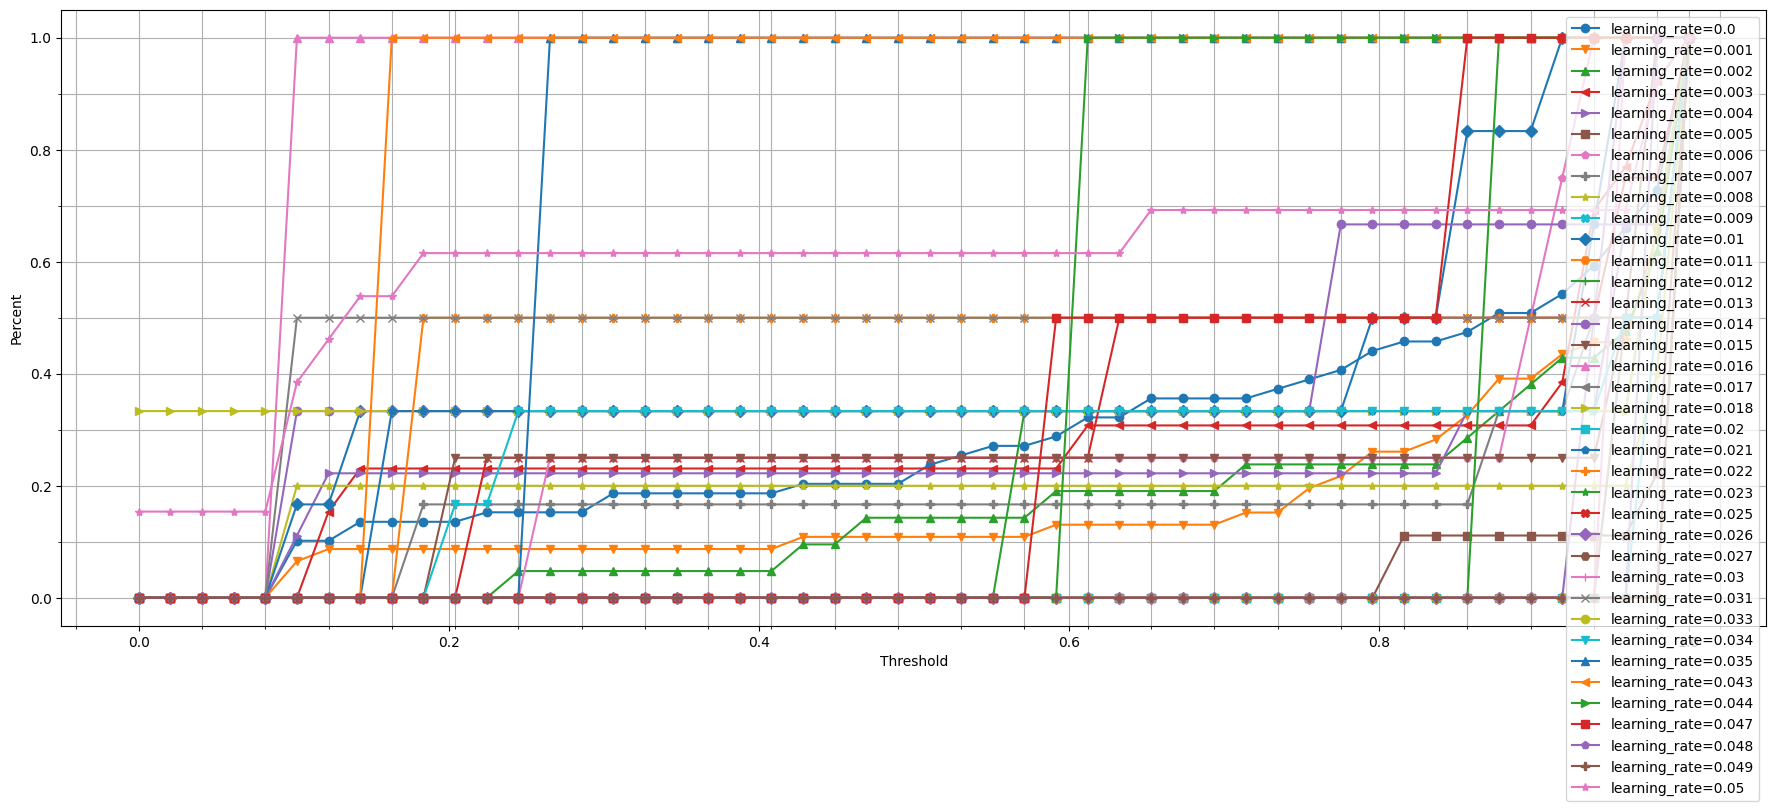

<Figure size 640x480 with 0 Axes>

In [369]:
categorical_accuracies = categorical_metric_analysis(rounded_full_res_df, ['learning_rate'], 'test_acc', True)

In [294]:
rounded_full_res_df.loc[rounded_full_res_df.duplicated()]

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition


In [295]:
2 * ((32-8) / 8) * ((64-32) / 8) * ((128-64) / 8) * ((128-64) / 8) * ((1024-8) / 8) * 3 * 3

1755648.0

In [296]:
((128-64) / 8)

8.0

### Experiment based graphs

In [80]:
good_res_df = full_res_df.loc[full_res_df['k'].isin([10, 25, 40])]
good_res_df['k'] = good_res_df['k'] / 10
good_res_df

<ipython-input-80-7c530254c0ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_res_df['k'] = good_res_df['k'] / 10


,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ff,fq,repetition,ftk,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.000131,0.561506,2.0,32,48,80.0,88.0,304,elu,BatchNorm,0.4340,0.4057,265.0,45000.0,CIFAR-10,0,0,example_forgetting,ucb,1.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.092518,0.699715,3.0,16,56,72.0,112.0,96,elu,Dropout,0.0000,0.0000,1.0,45000.0,CIFAR-10,0,1,example_forgetting,ucb,1.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001227,0.382351,3.0,24,48,88.0,88.0,304,elu,BatchNorm,0.4888,0.3770,330.0,45000.0,CIFAR-10,0,2,example_forgetting,ucb,1.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000100,1.000000,2.0,32,64,64.0,64.0,336,relu,None,0.5532,0.5262,199.0,45000.0,CIFAR-10,0,3,example_forgetting,ucb,1.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000100,1.000000,2.0,32,64,64.0,64.0,416,relu,None,0.5670,0.5307,208.0,45000.0,CIFAR-10,0,4,example_forgetting,ucb,1.0,10.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.003456,NaN,NaN,160,288,NaN,NaN,984,relu,NaN,0.9910,0.9827,61.0,2932.0,MNIST-LeNet2,132,95,example_forgetting,ucb,4.0,NaN,NaN,1,5.0,0.275261,NaN,NaN,0.460564,NaN,NaN,NaN,Momentum,0.0,NaN
96,0.000164,NaN,NaN,152,264,NaN,NaN,984,elu,NaN,0.9858,0.9752,83.0,2932.0,MNIST-LeNet2,132,96,example_forgetting,ucb,4.0,NaN,NaN,1,5.0,0.008180,NaN,NaN,0.740944,NaN,NaN,NaN,RMSProp,1.0,NaN
97,0.000740,NaN,NaN,128,224,NaN,NaN,704,tanh,NaN,0.1292,0.1293,8.0,2932.0,MNIST-LeNet2,132,97,example_forgetting,ucb,4.0,NaN,NaN,1,5.0,0.708417,NaN,NaN,0.891251,NaN,NaN,NaN,Adam,1.0,NaN
98,0.000218,NaN,NaN,128,240,NaN,NaN,1008,lrelu,NaN,0.9974,0.9885,46.0,2932.0,MNIST-LeNet2,132,98,example_forgetting,ucb,4.0,NaN,NaN,1,5.0,0.264997,NaN,NaN,0.697013,NaN,NaN,NaN,RMSProp,0.0,NaN


In [81]:
lenet1_res_df = good_res_df.loc[good_res_df['experiment_type'] == 'MNIST-LeNet1']
lenet2_res_df = good_res_df.loc[good_res_df['experiment_type'] == 'MNIST-LeNet2']
lenet3_res_df = good_res_df.loc[good_res_df['experiment_type'] == 'CIFAR-10']

no_lenet2_res_df = good_res_df.loc[good_res_df['experiment_type'] != 'MNIST-LeNet2']

lenet1_res_df.size, lenet2_res_df.size, lenet3_res_df.size, no_lenet2_res_df.size

(19754, 10200, 59738, 79492)

MNIST-LeNet1
Depreciated, use calculate_CED
k=1.0 | size: 174 | test_acc: 0.6620
Depreciated, use calculate_CED
k=2.5 | size: 213 | test_acc: 0.6562
Depreciated, use calculate_CED
k=4.0 | size: 194 | test_acc: 0.7070


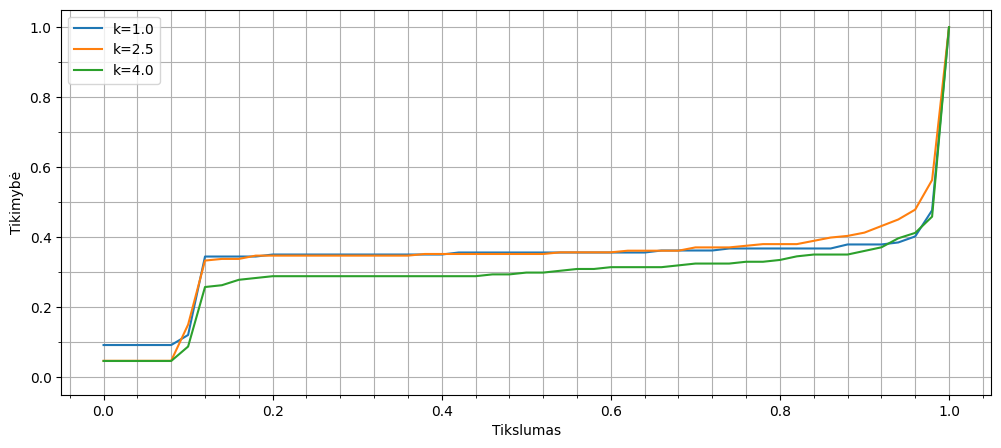

MNIST-LeNet2
Depreciated, use calculate_CED
k=4.0 | size: 300 | test_acc: 0.7529


<Figure size 640x480 with 0 Axes>

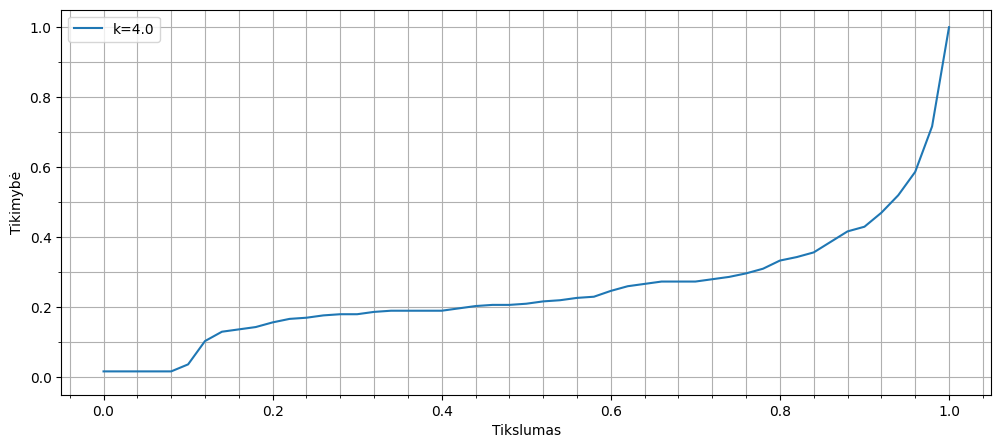

CIFAR-10
Depreciated, use calculate_CED
k=1.0 | size: 372 | test_acc: 0.4069
Depreciated, use calculate_CED
k=2.5 | size: 780 | test_acc: 0.4228
Depreciated, use calculate_CED
k=4.0 | size: 605 | test_acc: 0.4098


<Figure size 640x480 with 0 Axes>

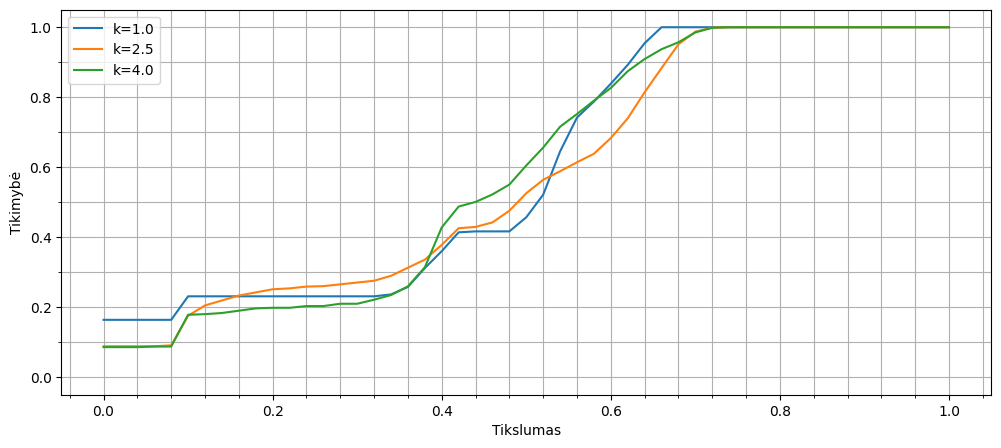

{1.0: 0.4069056451612903, 2.5: 0.4228405128205128, 4.0: 0.40982611570247934}

<Figure size 640x480 with 0 Axes>

In [82]:
print('MNIST-LeNet1')
categorical_metric_analysis(lenet1_res_df, ['k'], 'test_acc', True, False, (12, 5))
print('MNIST-LeNet2')
categorical_metric_analysis(lenet2_res_df, ['k'], 'test_acc', True, False, (12, 5))
print('CIFAR-10')
categorical_metric_analysis(lenet3_res_df, ['k'], 'test_acc', True, False, (12, 5))

In [88]:
display(lenet3_res_df.loc[lenet3_res_df['k'] == 1].sort_values('test_acc', ascending=False).head(1))
display(lenet3_res_df.loc[lenet3_res_df['k'] == 2.5].sort_values('test_acc', ascending=False).head(1))
display(lenet3_res_df.loc[lenet3_res_df['k'] == 4].sort_values('test_acc', ascending=False).head(1))

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ff,fq,repetition,ftk,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
9,0.009323,1.0,2.0,32,32,64.0,120.0,880,relu,Dropout,1.0,0.6573,307.0,44759.0,CIFAR-10,8,9,example_forgetting,ucb,1.0,5.0,5.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ff,fq,repetition,ftk,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
2,0.0671,0.001766,3.0,24,48,64.0,72.0,456,relu,BatchNorm,1.0,0.7252,218.0,45000.0,CIFAR-10,59,2,example_forgetting,ucb,2.5,NaN,NaN,1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ff,fq,repetition,ftk,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
41,0.1,0.0,3.0,32,64,64.0,112.0,288,relu,BatchNorm,0.991,0.727,180.0,34269.0,CIFAR-10,61,41,example_forgetting,ucb,4.0,NaN,NaN,1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Depreciated, use calculate_CED
k=10.0 | size: 546 | test_acc: 0.4882
Depreciated, use calculate_CED
k=25.0 | size: 993 | test_acc: 0.4729
Depreciated, use calculate_CED
k=40.0 | size: 799 | test_acc: 0.4820


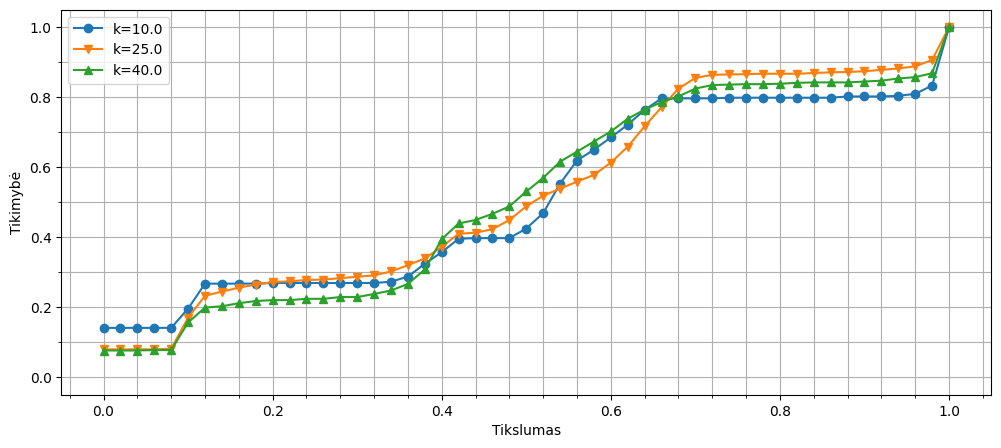

{10.0: 0.4881847985347985, 25.0: 0.4728966767371601, 40.0: 0.4819728410513141}

<Figure size 640x480 with 0 Axes>

In [58]:
categorical_metric_analysis(no_lenet2_res_df, ['k'], 'test_acc', True, (12, 5))

In [47]:
np.arange(0, 1.01, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [37]:
full_res_df = full_res_df.loc[full_res_df['task'] == 'MNIST-LeNet2']
full_res_df

,learning_rate,reg_param,conv1_depth,pool1_size,conv2_depth,pool2_size,window_size,fc_depth,dropout_rate,val_acc,test_acc,task,parameter,num,activation,optimizer,batch_normalization
0,0.000516,0.453607,16,NaN,248,NaN,NaN,16,0.6,0.0994,0.1032,MNIST-LeNet2,3,10,sigmoid,AdaGrad,0.0
1,0.001624,0.248109,296,NaN,112,NaN,NaN,736,0.3,0.9998,0.9911,MNIST-LeNet2,3,10,relu,RMSProp,0.0
2,0.001290,0.037859,288,NaN,120,NaN,NaN,744,0.4,0.9852,0.9790,MNIST-LeNet2,3,10,elu,AdaDelta,1.0
3,0.400000,1.000000,352,NaN,8,NaN,NaN,1024,0.0,0.1030,0.0974,MNIST-LeNet2,3,10,sigmoid,Momentum,0.0
4,0.000100,0.000000,272,NaN,176,NaN,NaN,624,0.6,0.8556,0.8564,MNIST-LeNet2,3,10,elu,AdaDelta,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.000100,1.000000,352,NaN,352,NaN,NaN,416,0.0,0.9896,0.9853,MNIST-LeNet2,505,40,tanh,Momentum,0.0
16,0.400000,1.000000,352,NaN,352,NaN,NaN,1024,0.0,1.0000,0.9934,MNIST-LeNet2,505,40,tanh,GD,1.0
17,0.400000,1.000000,176,NaN,352,NaN,NaN,552,0.0,0.1054,0.1028,MNIST-LeNet2,505,40,tanh,GD,0.0
18,0.000100,1.000000,352,NaN,176,NaN,NaN,688,0.9,0.9846,0.9851,MNIST-LeNet2,505,40,tanh,Momentum,0.0


In [38]:
full_res_df.corr()

<ipython-input-38-1945b4c2dee0>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  full_res_df.corr()


,learning_rate,reg_param,conv1_depth,pool1_size,conv2_depth,pool2_size,window_size,fc_depth,dropout_rate,val_acc,test_acc,batch_normalization
learning_rate,1.000000,-0.062249,-0.071030,NaN,0.122391,NaN,NaN,0.162208,0.081296,-0.038541,-0.042691,0.355558
reg_param,-0.062249,1.000000,-0.166817,NaN,0.077895,NaN,NaN,-0.039965,0.050466,-0.052109,-0.050500,-0.274457
conv1_depth,-0.071030,-0.166817,1.000000,NaN,-0.140550,NaN,NaN,0.201673,-0.046182,-0.008102,-0.007941,-0.142206
pool1_size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conv2_depth,0.122391,0.077895,-0.140550,NaN,1.000000,NaN,NaN,-0.037787,-0.197616,0.184803,0.182884,0.207363
pool2_size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
window_size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fc_depth,0.162208,-0.039965,0.201673,NaN,-0.037787,NaN,NaN,1.000000,0.134699,0.066551,0.066347,0.178026
dropout_rate,0.081296,0.050466,-0.046182,NaN,-0.197616,NaN,NaN,0.134699,1.000000,0.100891,0.103505,0.169124
val_acc,-0.038541,-0.052109,-0.008102,NaN,0.184803,NaN,NaN,0.066551,0.100891,1.000000,0.999917,0.385857


In [23]:
full_res_df['dropout_rate'] = [np.round(drop_rate, 1) for drop_rate in full_res_df['dropout_rate']]

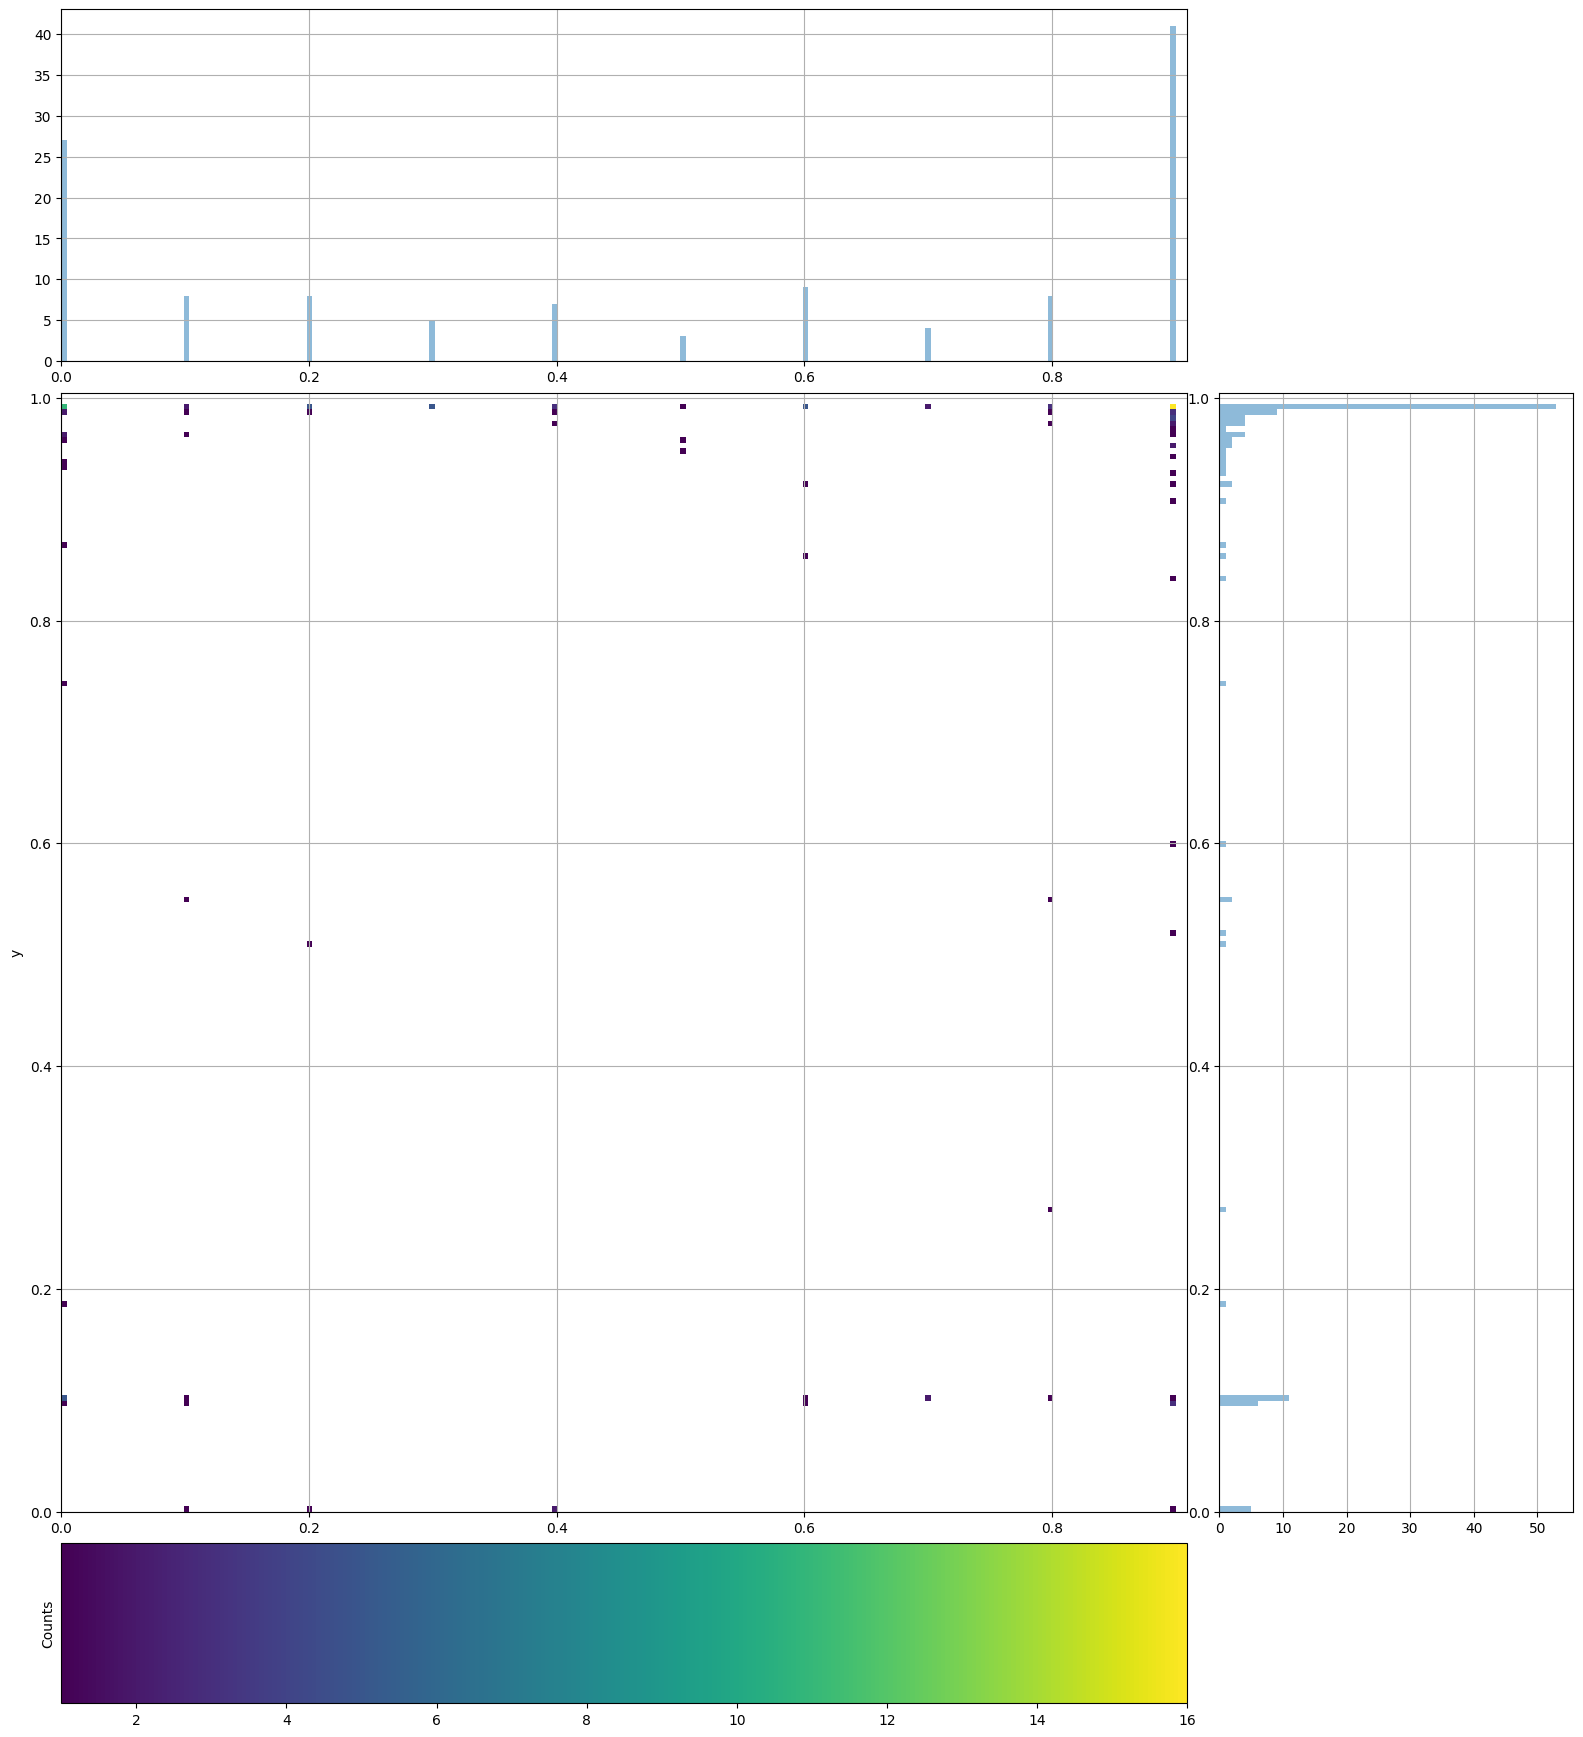

<Figure size 640x480 with 0 Axes>

In [34]:
sorted_values = full_res_df.sort_values('test_acc')[['dropout_rate', 'test_acc']]
plot_scatter_historgram(sorted_values['dropout_rate'], sorted_values['test_acc'])